# 01 - Exploratory Data Analysis (EDA)
**Project**: Preventing Injuries in Triathletes with Machine Learning using Wearable Sensor Data  
**Notebook**: 01 - Exploratory Data Analysis  
**Author**: Leonardo Rossi  

---

### Objective:
To understand the structure, quality, and patterns in the synthetic dataset to guide preprocessing, feature engineering, and model development.


In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import defaultdict
from scipy import stats


sns.set(style="whitegrid")


# Load data
athletes = pd.read_csv("../simulated_data/raw/athletes.csv")
activities = pd.read_csv("../simulated_data/raw/activity_data.csv")
daily_data = pd.read_csv("../simulated_data/raw/daily_data.csv")

## Data Overview
We explore the three core tables:
1. **Athlete Profiles** — Static data (age, gender, experience, lifestyle, performance metrics, ...)
2. **Daily Wearable Data** — Physiological signals (HRV, sleep, recovery, stress, ...)
3. **Daily Activity Data** — Training metrics (duration, intensity, sport specific metrics, ...)

In [231]:
# Check shapes and null values
for df, name in zip([athletes, daily_data, activities], ['athletes', 'daily_data', 'activities']):
    print(f"{name} → shape: {df.shape}, missing values:\n{df.isnull().sum()}\n")

athletes → shape: (1000, 26), missing values:
athlete_id                0
gender                    0
age                       0
height_cm                 0
weight_kg                 0
genetic_factor            0
hrv_baseline              0
hrv_range                 0
max_hr                    0
resting_hr                0
lthr                      0
hr_zones                  0
vo2max                    0
running_threshold_pace    0
ftp                       0
css                       0
training_experience       0
weekly_training_hours     0
recovery_rate             0
lifestyle                 0
sleep_time_norm           0
sleep_quality             0
nutrition_factor          0
stress_factor             0
smoking_factor            0
drinking_factor           0
dtype: int64

daily_data → shape: (366000, 15), missing values:
athlete_id              0
date                    0
resting_hr              0
hrv                     0
sleep_hours             0
deep_sleep              0
light_

## Merging Data
To perform injury prediction, we will merge the datasets on:
- `athlete_id`
- `date` (for daily data)

We aim to create one row per athlete per day with all available features.

Before we can do this we should aggregate the activities, in order to only have one row per athlete per day.

In [232]:
# Make sure 'date' is a datetime object
activities['date'] = pd.to_datetime(activities['date'])

# Define column groups for better organization
duration_cols = ['duration_minutes', 'tss']
intensity_cols = ['intensity_factor']
distance_cols = ['distance_km', 'avg_speed_kph']
hr_cols = ['avg_hr', 'max_hr']
power_cols = ['avg_power', 'normalized_power', 'work_kilojoules']
elevation_cols = ['elevation_gain']

# All numeric columns for aggregation 
agg_columns = duration_cols + intensity_cols + distance_cols + hr_cols + power_cols + elevation_cols

# Fill missing values with 0
activities[agg_columns] = activities[agg_columns].fillna(0)

# Group by athlete_id, date, sport and aggregate numeric columns
grouped = activities.groupby(['athlete_id', 'date', 'sport'])[agg_columns].sum().reset_index()

# Pivot so each sport gets its own column prefix
pivoted = grouped.pivot_table(
    index=['athlete_id', 'date'],
    columns='sport',
    values=agg_columns,
    fill_value=0
)

# Custom function to reorder MultiIndex columns
def reorder_columns(df):
    # Get all sports
    sports = df.columns.levels[1].tolist()
    
    # Create new column order
    new_order = []
    
    # First add all duration columns grouped by sport
    for col in duration_cols:
        for sport in sports:
            if (col, sport) in df.columns:
                new_order.append((col, sport))
    
    # Then add intensity columns
    for col in intensity_cols:
        for sport in sports:
            if (col, sport) in df.columns:
                new_order.append((col, sport))
    
    # Then distance metrics
    for col in distance_cols:
        for sport in sports:
            if (col, sport) in df.columns:
                new_order.append((col, sport))
    
    # Then heart rate metrics
    for col in hr_cols:
        for sport in sports:
            if (col, sport) in df.columns:
                new_order.append((col, sport))
    
    # Then power metrics
    for col in power_cols:
        for sport in sports:
            if (col, sport) in df.columns:
                new_order.append((col, sport))
    
    # Finally elevation metrics
    for col in elevation_cols:
        for sport in sports:
            if (col, sport) in df.columns:
                new_order.append((col, sport))
    
    # Return reordered DataFrame
    return df[new_order]

# Reorder columns by category
pivoted_ordered = reorder_columns(pivoted)

# Flatten the columns but preserve logical grouping
# Transform ('duration_minutes', 'run') → 'run_duration_minutes' to keep sports together
pivoted_ordered.columns = [f"{sport}_{metric}" for metric, sport in pivoted_ordered.columns]

# Reset index for clean merging
pivoted_ordered.reset_index(inplace=True)

# Helper function to handle zones column, keeping as a dictionary
def aggregate_zone_dictionaries(series):
    # Initialize empty dictionary to store aggregated values
    aggregated = defaultdict(float)
    
    for item in series.dropna():
        # Parse string to dict if needed
        if isinstance(item, str):
            try:
                zones = ast.literal_eval(item)
            except:
                continue
        elif isinstance(item, dict):
            zones = item
        else:
            continue
            
        # Add values for each zone
        for zone, value in zones.items():
            aggregated[zone] += float(value)
            
    return dict(aggregated) if aggregated else None

# Group and aggregate zone data by athlete, date, and sport
zone_data = activities.groupby(['athlete_id', 'date', 'sport']).agg({
    'hr_zones': aggregate_zone_dictionaries,
    'power_zones': aggregate_zone_dictionaries
}).reset_index()

# Pivot to create sport-specific zone columns while keeping dictionary format
zone_pivoted = zone_data.pivot(
    index=['athlete_id', 'date'],
    columns='sport',
    values=['hr_zones', 'power_zones']
)

# Flatten and rename columns to 'sport_hr_zones' and 'sport_power_zones'
zone_pivoted.columns = [f"{sport}_{zone_type}" for zone_type, sport in zone_pivoted.columns]
zone_pivoted.reset_index(inplace=True)

# Merge numeric features with zone features
final_df = pivoted_ordered.merge(zone_pivoted, on=['athlete_id', 'date'], how='left')

# Reorganize final columns to ensure athlete_id and date come first
cols = final_df.columns.tolist()
id_date_cols = ['athlete_id', 'date']
other_cols = [col for col in cols if col not in id_date_cols]

# Custom sort for other columns to group by sport
sports = activities['sport'].unique().tolist()
sorted_cols = []

for sport in sports:
    # Add columns for this sport in order (duration first, then other metrics)
    sport_cols = [col for col in other_cols if col.startswith(f"{sport}_")]
    
    # Sort to ensure duration comes first, followed by zones and other metrics
    duration_sport_cols = [col for col in sport_cols if "duration" in col]
    zone_sport_cols = [col for col in sport_cols if "_zones" in col]
    other_sport_cols = [col for col in sport_cols if col not in duration_sport_cols + zone_sport_cols]
    
    sorted_cols.extend(duration_sport_cols + zone_sport_cols + other_sport_cols)

# Final column order
final_cols = id_date_cols + sorted_cols
final_activities_df = final_df[final_cols]

# Preview result
final_activities_df.head()

,athlete_id,date,swim_duration_minutes,swim_hr_zones,swim_power_zones,swim_tss,swim_intensity_factor,swim_distance_km,swim_avg_speed_kph,swim_avg_hr,...,strength_tss,strength_intensity_factor,strength_distance_km,strength_avg_speed_kph,strength_avg_hr,strength_max_hr,strength_avg_power,strength_normalized_power,strength_work_kilojoules,strength_elevation_gain
0,006e66d8-101c-41f0-b541-44ee43f81058,2024-01-02,0.0,NaN,NaN,0.0,0.00,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,006e66d8-101c-41f0-b541-44ee43f81058,2024-01-03,0.0,NaN,NaN,0.0,0.00,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,006e66d8-101c-41f0-b541-44ee43f81058,2024-01-04,0.0,NaN,NaN,0.0,0.00,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,006e66d8-101c-41f0-b541-44ee43f81058,2024-01-05,0.0,NaN,NaN,0.0,0.00,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,006e66d8-101c-41f0-b541-44ee43f81058,2024-01-06,67.0,"{'Z1': 14.55223880597015, 'Z2': 4.477611940298...",None,89.0,0.89,4.813218,4.310345,167.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now that the activities are aggregated we can preceed and merge the three tables.

In [234]:
# Make sure 'date' is a datetime object
daily_data['date'] = pd.to_datetime(daily_data['date'])

# Merge daily + activity wearable device data
daily = pd.merge(daily_data, final_activities_df, on=['athlete_id', 'date'], how='inner')

# Add athlete profile data
merged = pd.merge(athletes, daily, on='athlete_id', how='left', suffixes=('_norm', '_daily'))

merged.to_pickle("../simulated_data/processed/merged.pkl")

merged.head()


,athlete_id,gender,age,height_cm,weight_kg,genetic_factor,hrv_baseline,hrv_range,max_hr,resting_hr_norm,...,strength_tss,strength_intensity_factor,strength_distance_km,strength_avg_speed_kph,strength_avg_hr,strength_max_hr,strength_avg_power,strength_normalized_power,strength_work_kilojoules,strength_elevation_gain
0,97edad40-801f-42c8-98fc-d0fce938c24f,female,35,164,57.7,0.91,97.5,"(np.float64(82.9), np.float64(112.1))",187.5,44.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,97edad40-801f-42c8-98fc-d0fce938c24f,female,35,164,57.7,0.91,97.5,"(np.float64(82.9), np.float64(112.1))",187.5,44.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,97edad40-801f-42c8-98fc-d0fce938c24f,female,35,164,57.7,0.91,97.5,"(np.float64(82.9), np.float64(112.1))",187.5,44.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,97edad40-801f-42c8-98fc-d0fce938c24f,female,35,164,57.7,0.91,97.5,"(np.float64(82.9), np.float64(112.1))",187.5,44.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,97edad40-801f-42c8-98fc-d0fce938c24f,female,35,164,57.7,0.91,97.5,"(np.float64(82.9), np.float64(112.1))",187.5,44.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Analysis

### 1. Assessing the quality and realism of the synthetic Dataset

#### Basic Assessements:
- how rare are injuries?
- are key physiological metrics within realistic bounds?
- do the distributions correspond to the represented group of competitive age groupers?
- are physiological metrics appropriately correlated?

Injury Distribution:
injury
0    0.918117
1    0.081883
Name: proportion, dtype: float64


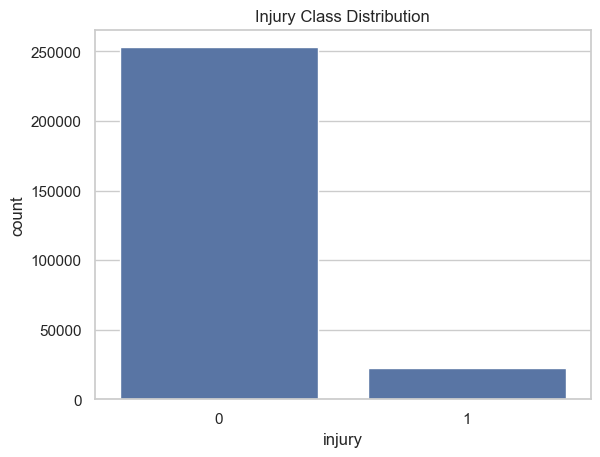

In [99]:
print("Injury Distribution:")
print(merged['injury'].value_counts(normalize=True))

sns.countplot(data=merged, x='injury')
plt.title("Injury Class Distribution")
plt.show()

As expected injuries are much rarer than non injuries, in fact only 8.19% of days are injury days. This serious class imbalance needs to be addressed in order to avoid bias against the minority class, leading to many false negeatives.

In [100]:
# Summary stats
merged.describe()

,age,height_cm,weight_kg,genetic_factor,hrv_baseline,max_hr,resting_hr_norm,lthr,vo2max,running_threshold_pace,...,strength_tss,strength_intensity_factor,strength_distance_km,strength_avg_speed_kph,strength_avg_hr,strength_max_hr,strength_avg_power,strength_normalized_power,strength_work_kilojoules,strength_elevation_gain
count,275527.000000,275527.000000,275527.000000,275527.000000,275527.000000,275527.000000,275527.000000,275527.000000,275527.000000,275527.000000,...,275527.000000,275527.000000,275527.0,275527.0,275527.000000,275527.000000,275527.0,275527.0,275527.0,275527.0
mean,32.535287,172.249587,66.709477,0.995922,101.197070,187.429692,47.324929,183.740113,69.104376,3.918646,...,0.796361,0.031858,0.0,0.0,6.933803,9.155317,0.0,0.0,0.0,0.0
min,18.000000,150.000000,37.200000,0.800000,75.000000,168.300000,38.000000,160.000000,50.000000,3.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,29.000000,165.000000,56.400000,0.940000,94.500000,182.900000,43.600000,179.000000,65.900000,3.110000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,33.000000,172.000000,67.600000,1.000000,100.500000,187.200000,47.100000,188.000000,70.000000,3.740000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,37.000000,179.000000,76.200000,1.060000,106.500000,192.100000,50.900000,190.000000,75.000000,4.530000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
max,50.000000,200.000000,94.600000,1.200000,123.000000,217.900000,60.000000,190.000000,75.000000,5.500000,...,435.000000,0.840000,0.0,0.0,165.000000,208.000000,0.0,0.0,0.0,0.0
std,5.864377,9.342476,11.539818,0.088260,8.796565,7.048554,5.256360,8.161613,5.637854,0.839911,...,5.602184,0.140550,0.0,0.0,30.486212,40.248966,0.0,0.0,0.0,0.0


The following observations can be made (relative):

- high mean HRV
- low resting heart rates
- high lactate threshold heart rate compared to max heart rate
- high vo2max
- fast running threshold paces
- high mean ftp compared to mean weight
- 11.8 mean weekly training hours
- planned and actual tss means are very close indicating that the represented athletes execute their plan well

together these observations indicate the fitness level of the population is high, but given the relatively low training volume professional status is unlikely.

This aligns with the target population of the synthetic data generation.


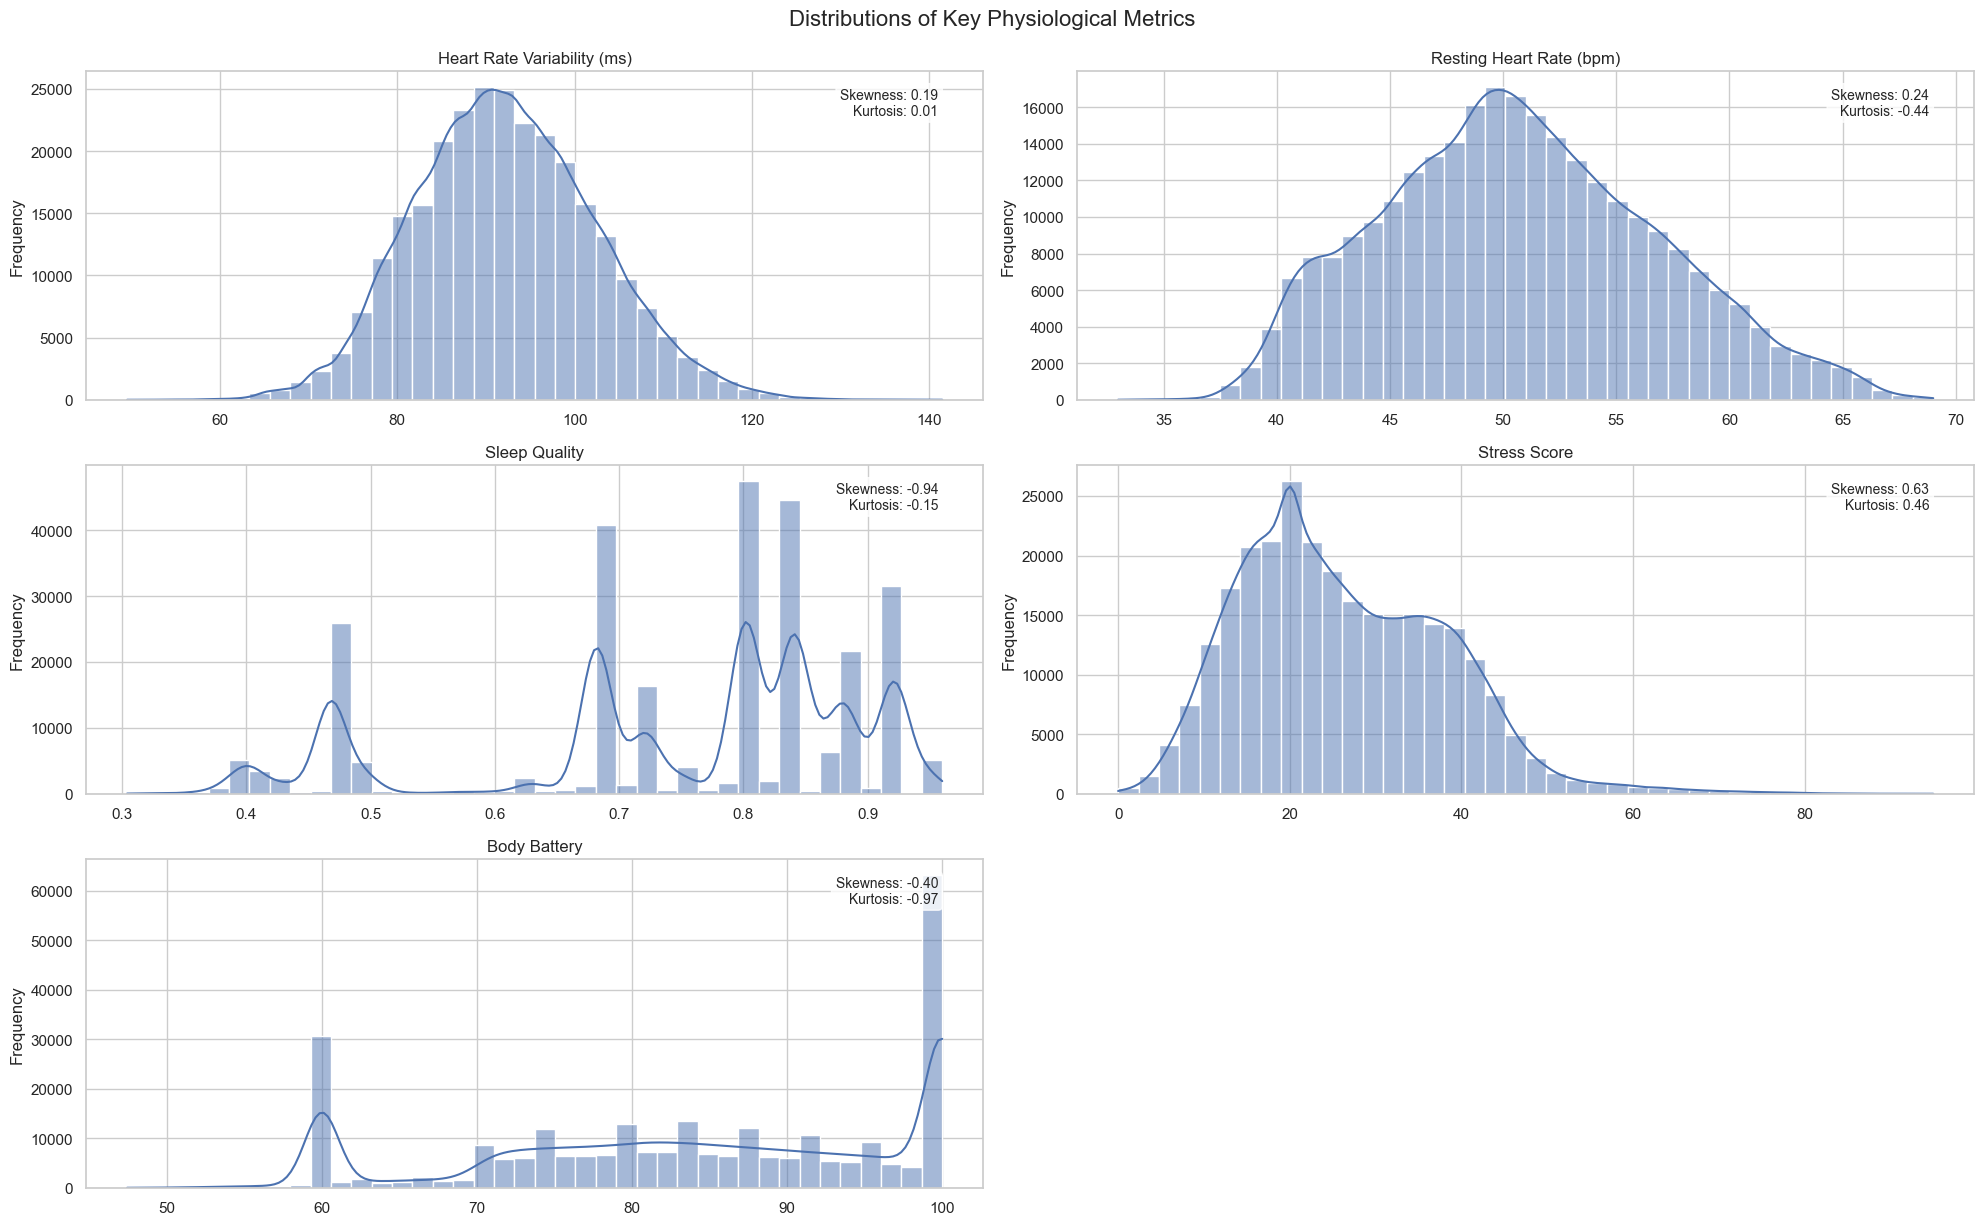

In [167]:
from scipy.stats import skew, kurtosis

metrics = {
    'hrv': 'Heart Rate Variability (ms)',
    'resting_hr_daily': 'Resting Heart Rate (bpm)',
    'sleep_quality_daily': 'Sleep Quality',
    'stress': 'Stress Score',
    'body_battery_morning': 'Body Battery'
}

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 12))
axes = axes.flatten()

# Loop through each metric and create a histogram with KDE
for i, (col, label) in enumerate(metrics.items()):
    if col in merged.columns:
        data = merged[col].dropna()
        skewness = skew(data)
        kurt = kurtosis(data)

        sns.histplot(data, kde=True, bins=40, ax=axes[i])
        axes[i].set_title(label)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True)

        # Add text box with basic stats
        stats_text = f"Skewness: {skewness:.2f}\nKurtosis: {kurt:.2f}"
        axes[i].text(0.95, 0.95, stats_text, transform=axes[i].transAxes,
                     fontsize=10, verticalalignment='top', horizontalalignment='right',
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        axes[i].set_visible(False)

# Hide any extra subplots
for j in range(len(metrics), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.suptitle('Distributions of Key Physiological Metrics', fontsize=16, y=1.02)
plt.show()


In [174]:
# Define thresholds
brady_threshold = 60
brady_severe = 50
brady_critical = 40

# Filter based on thresholds
total_count = merged['resting_hr_daily'].count()

brady_count = merged[merged['resting_hr_daily'] < brady_threshold].shape[0]
severe_brady_count = merged[merged['resting_hr_daily'] < brady_severe].shape[0]
critical_brady_count = merged[merged['resting_hr_daily'] < brady_critical].shape[0]

# Calculate percentages
brady_pct = (brady_count / total_count) * 100
severe_brady_pct = (severe_brady_count / total_count) * 100
critical_brady_pct = (critical_brady_count / total_count) * 100

# Display results
print(f"RHR < 60 bpm (Bradycardia): {brady_pct:.2f}% of entries")
print(f"RHR < 50 bpm (Severe Bradycardia): {severe_brady_pct:.2f}% of entries")
print(f"RHR < 40 bpm (Critical Bradycardia): {critical_brady_pct:.2f}% of entries")

total_stress_count = merged['stress'].count()
high_stress_count = merged[merged['stress'] > 50].shape[0]
high_stress_pct = (high_stress_count / total_stress_count) * 100
print(f"Medium - High Stress (> 50): {high_stress_pct:.2f}% of entries")

# Define thresholds for sleep quality
sleep_quality_optimal = 0.75
sleep_quality_adequate = 0.6

total_sleep_count = merged['sleep_quality_daily'].count()

# Filter based on thresholds
optimal_sleep_count = merged[merged['sleep_quality_daily'] > sleep_quality_optimal].shape[0]
adequate_sleep_count = merged[merged['sleep_quality_daily'] >= sleep_quality_adequate].shape[0] - optimal_sleep_count
poor_sleep_count = merged[merged['sleep_quality_daily'] < sleep_quality_adequate].shape[0]

# Calculate percentages
optimal_sleep_pct = (optimal_sleep_count / total_sleep_count) * 100
adequate_sleep_pct = (adequate_sleep_count / total_sleep_count) * 100
poor_sleep_pct = (poor_sleep_count / total_sleep_count) * 100
# Display results
print(f"Optimal Sleep Quality (> 0.75): {optimal_sleep_pct:.2f}% of entries")
print(f"Adequate Sleep Quality (>= 0.6): {adequate_sleep_pct:.2f}% of entries")
print(f"Poor Sleep Quality (< 0.6): {poor_sleep_pct:.2f}% of entries")


RHR < 60 bpm (Bradycardia): 92.46% of entries
RHR < 50 bpm (Severe Bradycardia): 47.12% of entries
RHR < 40 bpm (Critical Bradycardia): 2.07% of entries
Medium - High Stress (> 50): 2.60% of entries
Optimal Sleep Quality (> 0.75): 59.13% of entries
Adequate Sleep Quality (>= 0.6): 24.46% of entries
Poor Sleep Quality (< 0.6): 16.40% of entries


1. **Heart Rate Variability (HRV)**
- **Distribution:** Approximately normal, centered around **90–100 ms**
- **Range:** Roughly **60–120 ms**
- This is physiologically realistic for trained endurance athletes, supporting the plausibility of the HRV generation process.

---

2. **Resting Heart Rate (RHR)**
- **Distribution:** Slight right-skew, with a central tendency around **48–50 bpm**
- **Range:** Roughly **35–65 bpm**
- Matches expectations for a highly trained population, where lower resting HR is common due to cardiovascular efficiency.

---

3. **Sleep Quality**
- **Distribution:** Multimodal, with distinct peaks around **0.5**, **0.7**, and **0.8–0.9**
- Suggests the model simulates different sleep quality states (e.g., poor, average, good), which is more realistic than a continuous Gaussian model. This reflects how athletes’ sleep often clusters around typical levels. It also aligns with the modeled lifestyles that determine different sleep behaviors.

---

4. **Stress Score**
- **Distribution:** Bimodal, with peaks around **20** and **35**
- Likely represents alternating low-stress and high-stress days, consistent with training cycles, life stressors, or competition periods.
- Indicates the model may be capturing cyclical variation in athlete stress levels, which enhances data realism.

---

5. **Body Battery (Morning)**
- **Distribution:** Unusual, with strong peaks at **60** and **100**
- Unveals that the model is using explicit upper and lower bounds:
  - **100** = fully recovered
  - **60** = common partial recovery state
- This reflects a partially rule-based system rather than a naturally distributed variable.

---

**Summary**

Most physiological metrics show distributions that are plausible and aligned with sports science literature:
- HRV and RHR follow expected patterns for endurance athletes.
- Sleep and stress reflect state-based variability, adding depth and complexity.

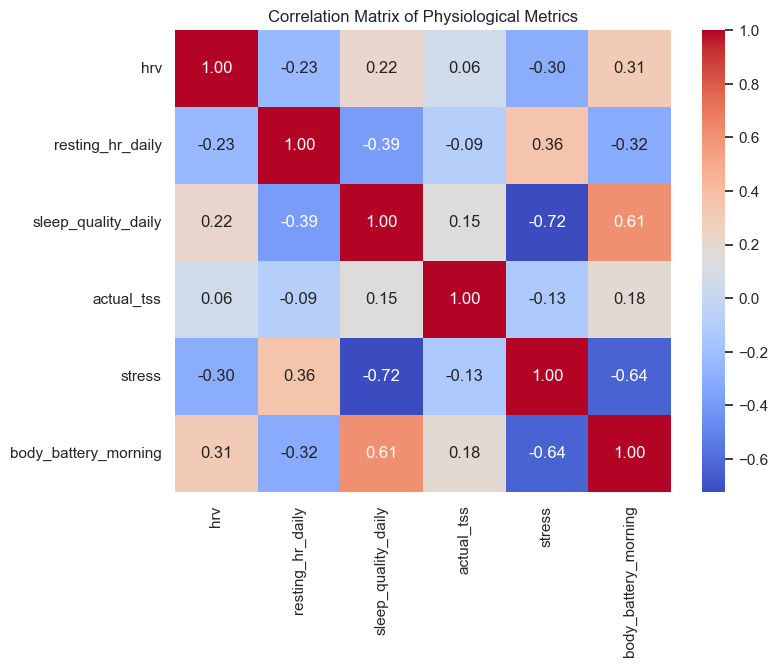

In [129]:
# Select relevant columns
metrics = merged[['hrv', 'resting_hr_daily', 'sleep_quality_daily', 'actual_tss', 'stress', 'body_battery_morning']]
correlation_matrix = metrics.corr()

# Visualize with heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Physiological Metrics')
plt.show()

1. **HRV:**
- **Negative correlation** with **Resting Heart Rate** (`-0.23`)  
  ↳ Higher HRV typically indicates better recovery and lower resting HR — physiologically sound  
- **Positive correlation** with:
  - **Sleep Quality** (`0.22`)  
  - **Body Battery (Morning)** (`0.31`)  
  ↳ Suggests better recovery states are associated with higher HRV
- **Negative correlation** with **Stress** (`-0.30`)  
  ↳ Higher stress is typically associated with reduced HRV

---

2. **Resting Heart Rate:**
- **Negative correlation** with **Sleep Quality** (`-0.39`)  
  ↳ Poor sleep may elevate resting HR  
- **Positive correlation** with **Stress** (`0.36`)  
  ↳ Aligns with expectation that stress elevates HR  
- **Negative correlation** with **Body Battery Morning** (`-0.32`)  
  ↳ Higher resting HR is often a sign of lower recovery reserves

---

3. **Sleep Quality:**
- **Strong negative correlation** with **Stress** (`-0.72`)  
  ↳ Clear inverse relationship: high stress → poor sleep  
- **Strong positive correlation** with **Body Battery Morning** (`0.61`)  
  ↳ Reinforces sleep's critical role in recovery  
- **Weak positive correlation** with **Training Load (actual_tss)** (`0.15`)

---

4. **Training Load:**
- **Weaker correlations** with most physiological markers — consistent with complex recovery dynamics  
- Slight **positive correlation** with:
  - **Body Battery Morning** (`0.18`)
  - **Sleep Quality** (`0.15`)
- Slight **negative correlation** with **Stress** (`-0.13`)

5. **Stress:**
- **Strong negative correlation** with:
  - **Sleep Quality** (`-0.72`)
  - **Body Battery Morning** (`-0.64`)  
- **Positive correlation** with **Resting HR** (`0.36`)  
  ↳ Suggests that higher stress disrupts both recovery and cardiac efficiency

---

6. **Morning Body battery:**
- **Strong positive correlation** with **Sleep Quality** (`0.61`)
- **Strong negative correlation** with **Stress** (`-0.64`)
- **Moderate positive correlation** with **HRV** (`0.31`)
- **Moderate negative correlation** with **Resting HR** (`-0.32`)

---

The observed correlations are consistent with known physiological relationships, validating the plausibility of the synthetic dataset. Notably:
- **Stress and Sleep Quality**: Highly inverse — a hallmark of realistic recovery modeling
- **HRV and Resting HR**: Show classic opposing patterns
- **Training Load**'s weak but present influence reflects the **non-linear and individual nature of recovery**

#### **Training Responses and Behaviors**
- do high load days have expected effects on recovery metrics?
- do athletes train smartly, in injury avoiding ways?
- how are loads distributed among the disciplines (cycling, swimming and running)?

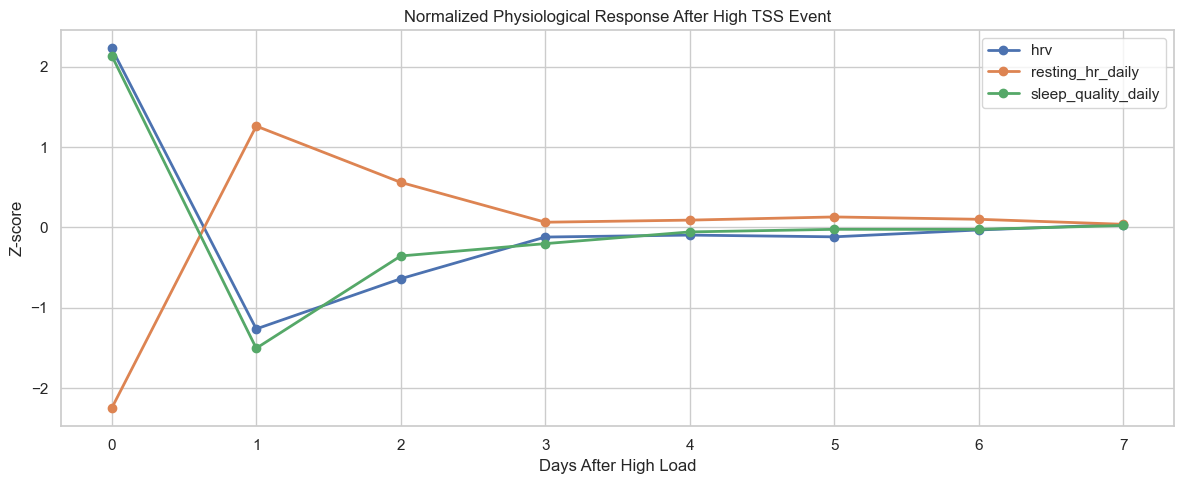

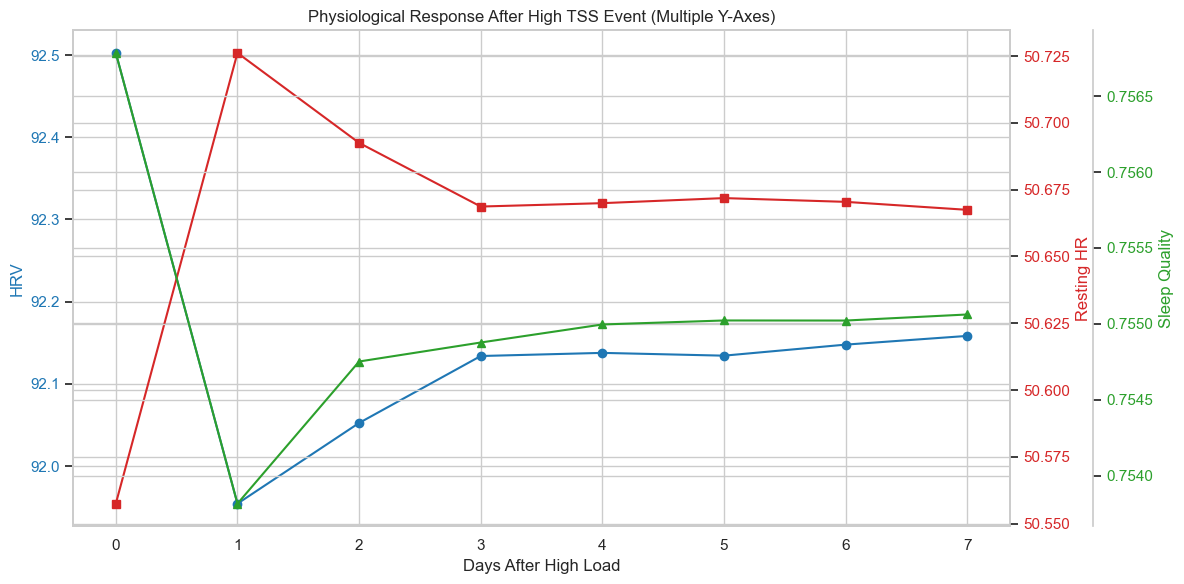

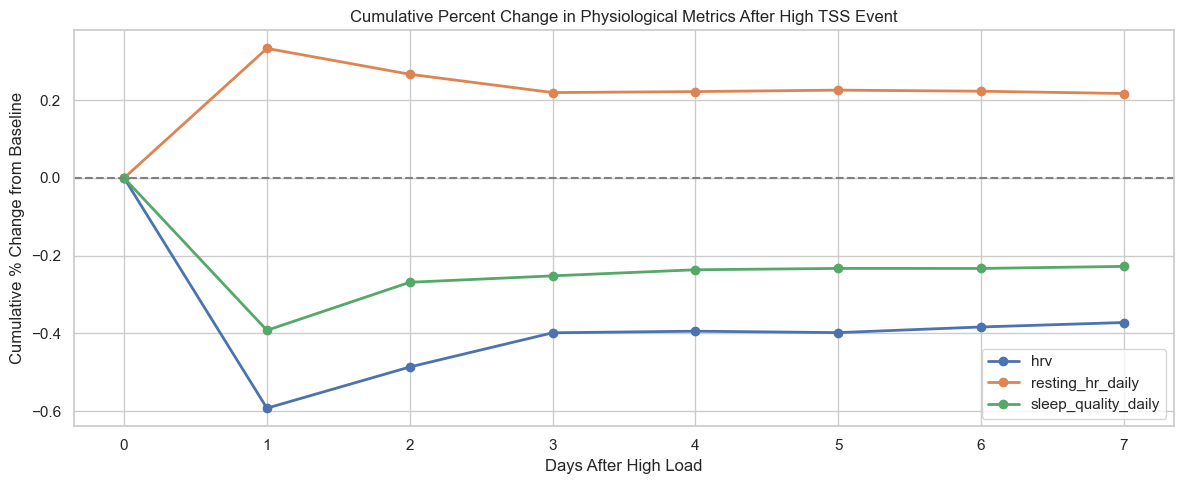

In [ ]:
# Tag "high load" days (e.g. top 10% TSS days)
merged['high_load'] = merged['actual_tss'] > merged['actual_tss'].quantile(0.9)

# Align physiological responses after those days (7-day window)
window = 7
responses = []

for athlete_id, group in merged.groupby('athlete_id'):
    group = group.sort_values('date')
    indices = group.index[group['high_load']]

    for idx in indices:
        # Make sure we don't go out of bounds
        if idx + window < group.index[-1]:
            response = group.loc[idx:idx+window][['hrv', 'resting_hr_daily', 'sleep_quality_daily']].reset_index(drop=True)
            responses.append(response)

# Average response per day across athletes
avg_response = pd.concat(responses).groupby(level=0).mean()

# Normalize (z-score)
avg_response_norm = (avg_response - avg_response.mean()) / avg_response.std()

# ------------------------------
# Plot 1: Normalized Responses
# ------------------------------
plt.figure(figsize=(12, 5))
for col in avg_response_norm.columns:
    plt.plot(avg_response_norm[col], marker='o', linewidth=2, label=col)

plt.title('Normalized Physiological Response After High TSS Event')
plt.xlabel('Days After High Load')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------
# Plot 2: Multiple Y-Axes
# ------------------------------
fig, ax1 = plt.subplots(figsize=(12, 6))

# First axis: HRV
color1 = 'tab:blue'
ax1.set_xlabel('Days After High Load')
ax1.set_ylabel('HRV', color=color1)
ax1.plot(avg_response['hrv'], marker='o', color=color1, label='HRV')
ax1.tick_params(axis='y', labelcolor=color1)

# Second axis: Resting HR
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Resting HR', color=color2)
ax2.plot(avg_response['resting_hr_daily'], marker='s', color=color2, label='Resting HR')
ax2.tick_params(axis='y', labelcolor=color2)

# Third axis: Sleep Quality
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
color3 = 'tab:green'
ax3.set_ylabel('Sleep Quality', color=color3)
ax3.plot(avg_response['sleep_quality_daily'], marker='^', color=color3, label='Sleep Quality')
ax3.tick_params(axis='y', labelcolor=color3)

# Title and layout
plt.title('Physiological Response After High TSS Event (Multiple Y-Axes)')
fig.tight_layout()
plt.show()

# ------------------------------
# Plot 3: Cumulative % Change
# ------------------------------
pct_change = avg_response.pct_change().fillna(0) * 100
cumulative_pct = (1 + pct_change/100).cumprod() - 1
cumulative_pct = cumulative_pct * 100

plt.figure(figsize=(12, 5))
for col in ['hrv', 'resting_hr_daily', 'sleep_quality_daily']:
    plt.plot(cumulative_pct[col], marker='o', linestyle='-', linewidth=2, label=col)
plt.title('Cumulative Percent Change in Physiological Metrics After High TSS Event')
plt.xlabel('Days After High Load')
plt.ylabel('Cumulative % Change from Baseline')
plt.axhline(y=0, color='gray', linestyle='--')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

1. **Day 0:** The starting point shows elevated HRV and sleep quality (positive z-scores) with depressed resting heart rate (negative z-score), suggesting athletes are well-recovered immediately before their high-load sessions.

2. **Day 1:** Shows a dramatic physiological response with:

- HRV plummeting (approximately -2 z-scores)
- Sleep quality dropping significantly (around -1.8 z-scores)
- Resting heart rate spiking considerably (over +2 z-scores)

    This pattern perfectly captures the expected acute physiological stress response after intensive training.

3. **Days 2-7:** Shows a gradual recovery pattern:

- HRV and sleep quality gradually improve, returning to baseline around day 4 and continuing slightly above baseline
- Resting heart rate gradually decreases, dropping below baseline after day 4

    This models a realistic 3-4 day recovery window typical in athletes following high load training.

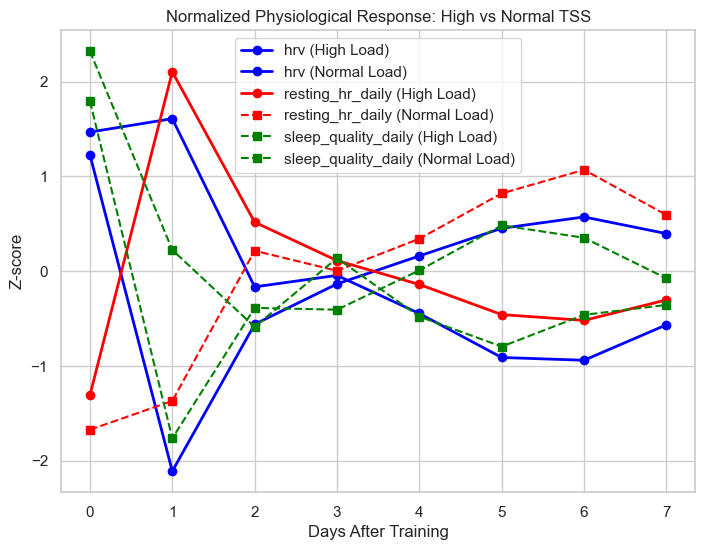

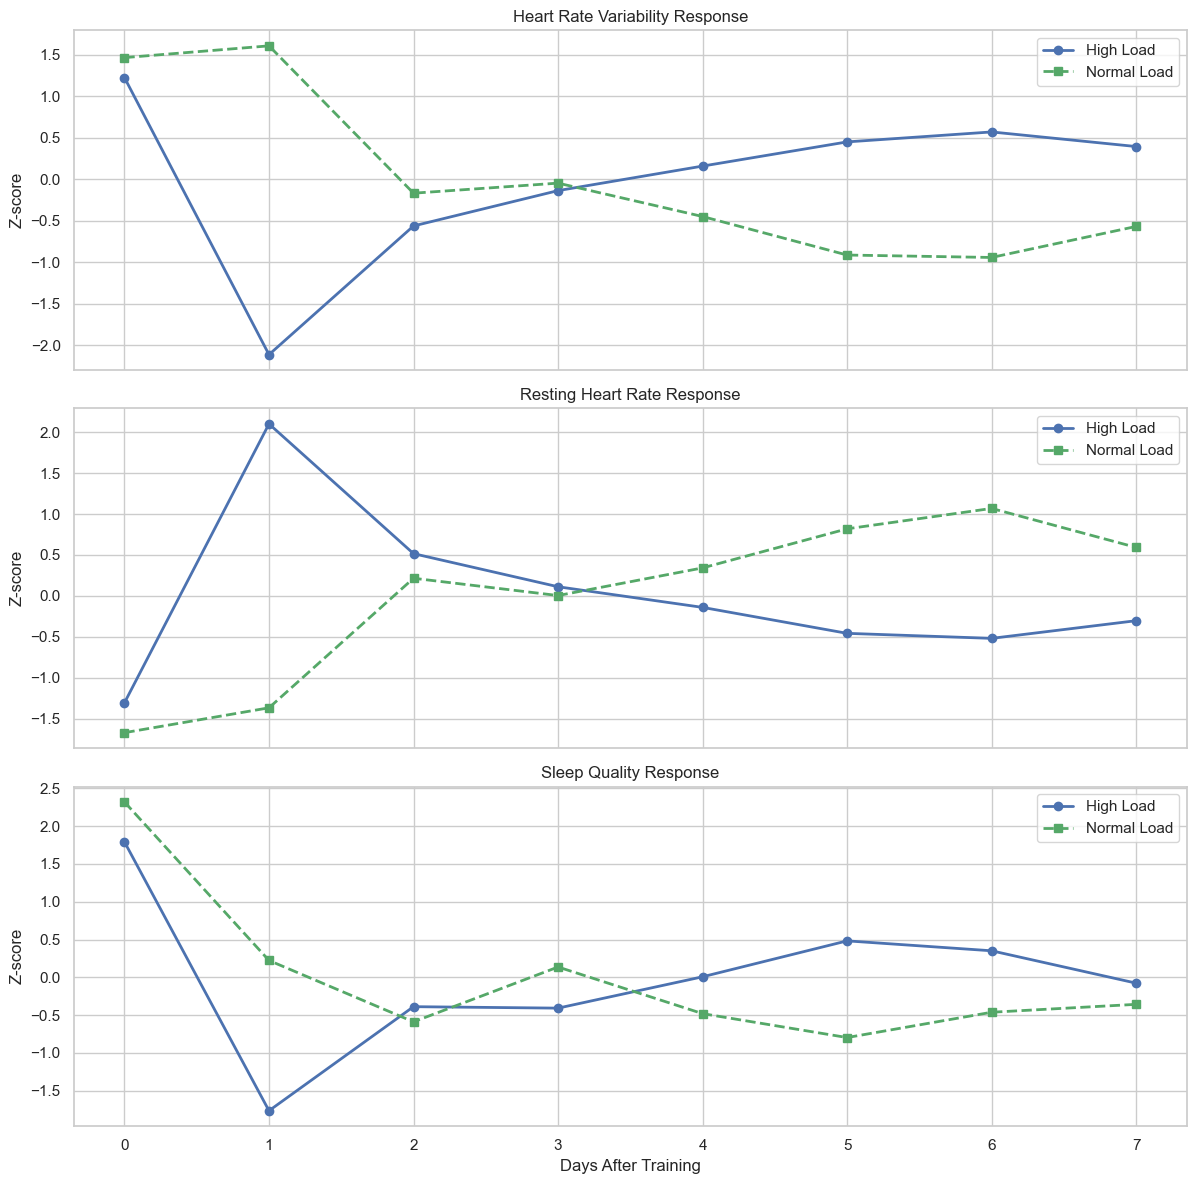

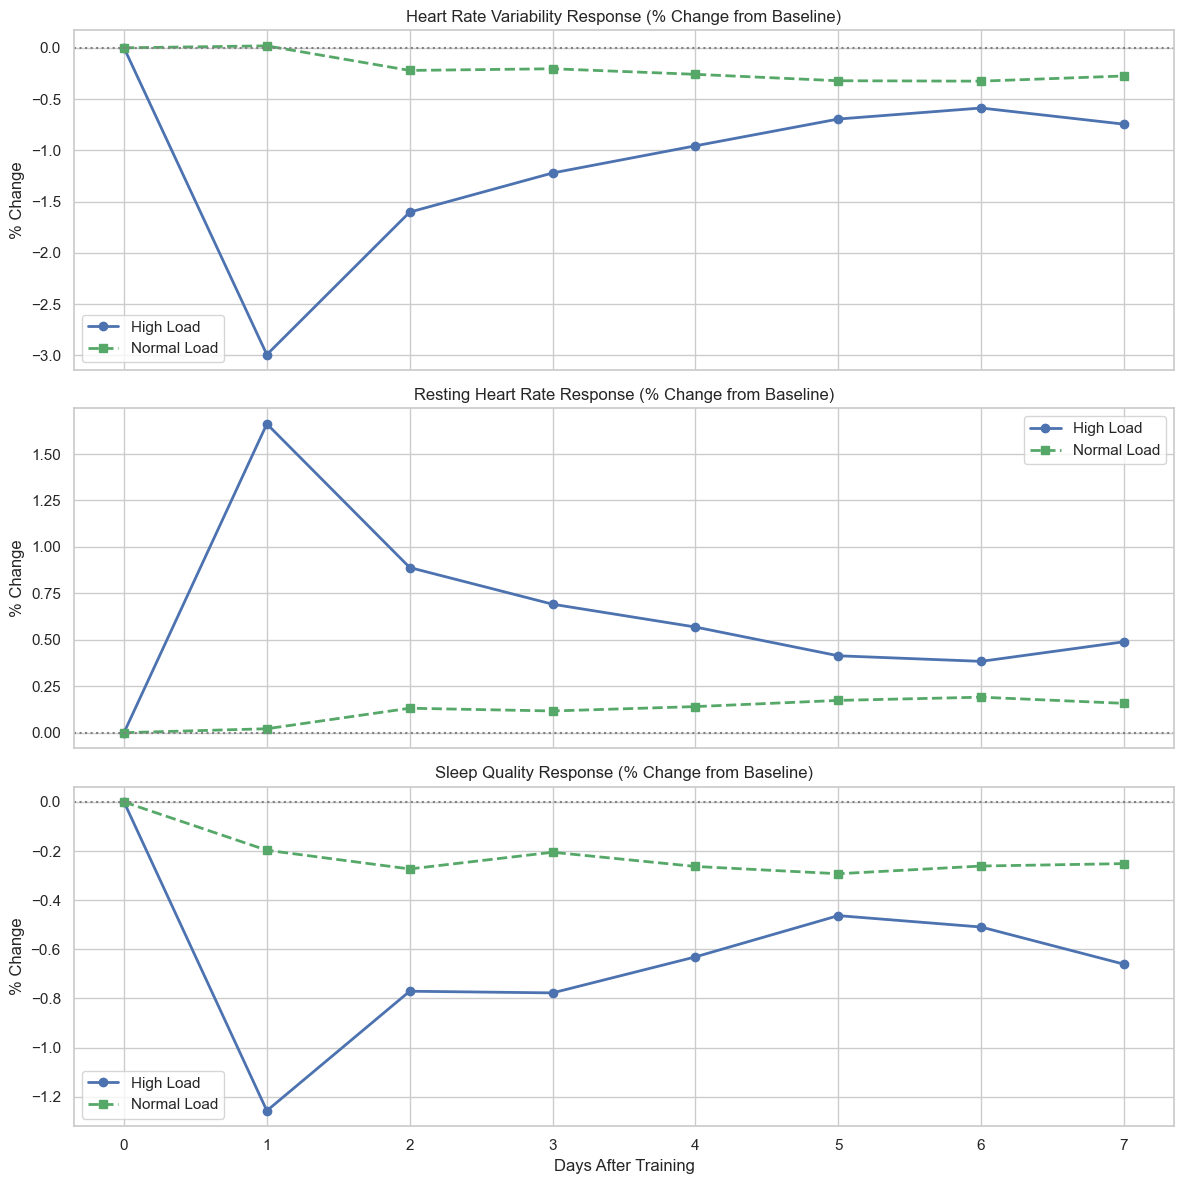

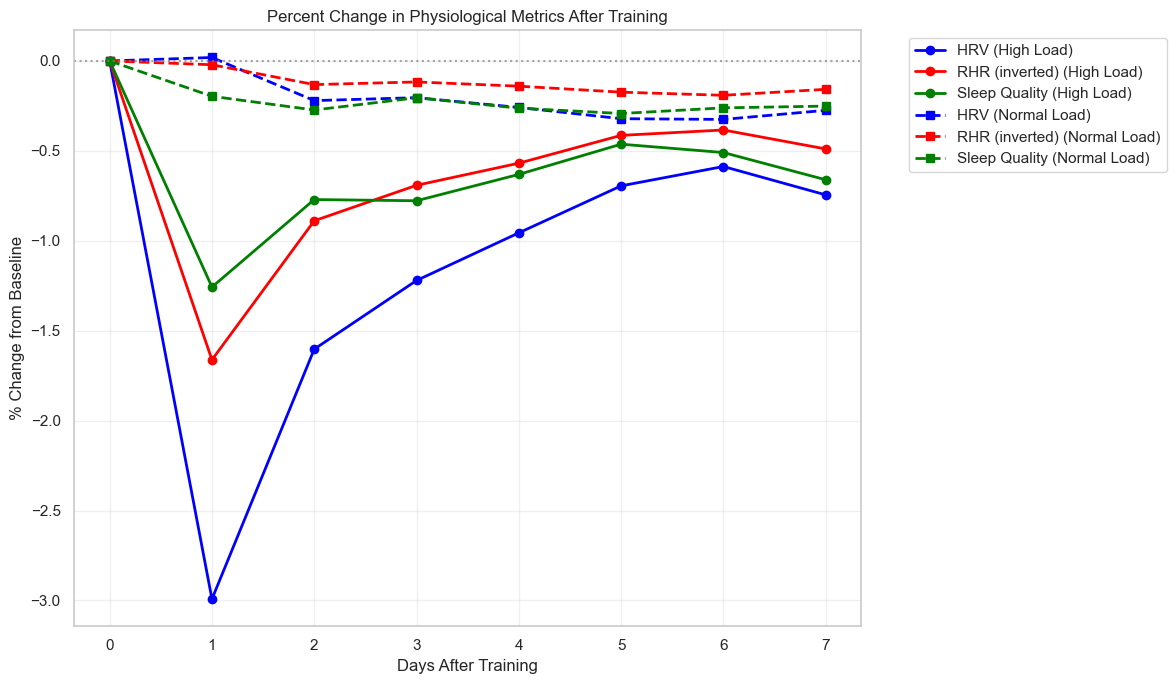

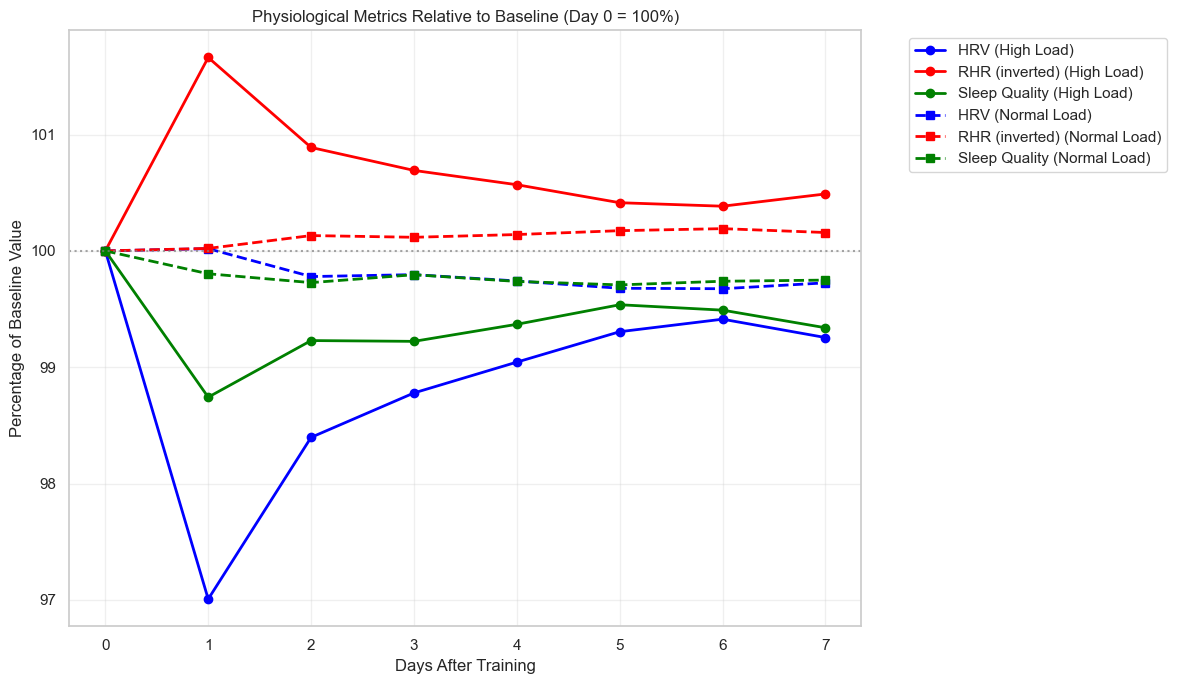

In [182]:
# Define both high and normal load days
# High load = top 10% TSS days
# Normal load = middle 40-60% percentile (to avoid low recovery days)
merged['high_load'] = merged['actual_tss'] > merged['actual_tss'].quantile(0.9)
merged['normal_load'] = (merged['actual_tss'] > merged['actual_tss'].quantile(0.4)) & (merged['actual_tss'] < merged['actual_tss'].quantile(0.6))

# Function to extract responses for a given condition
def extract_responses(data, condition_col, window=7):
    responses = []
    for athlete_id, group in data.groupby('athlete_id'):
        group = group.sort_values('date')
        indices = group.index[group[condition_col]]
        for idx in indices:
            # Make sure we don't go out of bounds
            if idx + window < group.index[-1]:
                response = group.loc[idx:idx+window][['hrv', 'resting_hr_daily', 'sleep_quality_daily']].reset_index(drop=True)
                responses.append(response)
    
    # Average response per day across athletes
    if responses:
        avg_response = pd.concat(responses).groupby(level=0).mean()
        # Normalize (z-score)
        avg_response_norm = (avg_response - avg_response.mean()) / avg_response.std()
        return avg_response, avg_response_norm
    else:
        return None, None

# Extract responses for high load days
high_responses, high_responses_norm = extract_responses(merged, 'high_load')

# Extract responses for normal load days
normal_responses, normal_responses_norm = extract_responses(merged, 'normal_load')

# Create comparison plots
plt.figure(figsize=(18, 6))

# 1. Normalized comparison - all metrics together
plt.subplot(1, 2, 1)
metrics = ['hrv', 'resting_hr_daily', 'sleep_quality_daily']
linestyles = ['-', '--']
colors = {'hrv': 'blue', 'resting_hr_daily': 'red', 'sleep_quality_daily': 'green'}

for i, (metric_name, response_type, response_data) in enumerate(
    [(m, t, d) for m in metrics for t, d in 
     [('High Load', high_responses_norm), ('Normal Load', normal_responses_norm)]]):
    
    plt.plot(response_data[metric_name], 
             linestyle=linestyles[i//3], 
             color=colors[metric_name],
             marker='o' if i < 3 else 's',
             linewidth=2 if i < 3 else 1.5,
             label=f"{metric_name} ({response_type})")

plt.title('Normalized Physiological Response: High vs Normal TSS')
plt.xlabel('Days After Training')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)

# 2. Separate subplot for each metric
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
metric_titles = {'hrv': 'Heart Rate Variability', 
                'resting_hr_daily': 'Resting Heart Rate', 
                'sleep_quality_daily': 'Sleep Quality'}

for i, metric in enumerate(metrics):
    axes[i].plot(high_responses_norm[metric], 'b-', marker='o', linewidth=2, label='High Load')
    axes[i].plot(normal_responses_norm[metric], 'g--', marker='s', linewidth=2, label='Normal Load')
    axes[i].set_title(f'{metric_titles[metric]} Response')
    axes[i].set_ylabel('Z-score')
    axes[i].grid(True)
    axes[i].legend()

axes[2].set_xlabel('Days After Training')
plt.tight_layout()

# 3. Optional: Plot absolute values instead of normalized values
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

for i, metric in enumerate(metrics):
    # Calculate percent change from day 0
    high_pct = high_responses[metric] / high_responses[metric].iloc[0] * 100 - 100
    normal_pct = normal_responses[metric] / normal_responses[metric].iloc[0] * 100 - 100
    
    axes[i].plot(high_pct, 'b-', marker='o', linewidth=2, label='High Load')
    axes[i].plot(normal_pct, 'g--', marker='s', linewidth=2, label='Normal Load')
    axes[i].set_title(f'{metric_titles[metric]} Response (% Change from Baseline)')
    axes[i].set_ylabel('% Change')
    axes[i].axhline(y=0, color='gray', linestyle=':')
    axes[i].grid(True)
    axes[i].legend()

axes[2].set_xlabel('Days After Training')
plt.tight_layout()

plt.show()

# After running your extract_responses function for high and normal loads:

# Create a single plot for percent changes
plt.figure(figsize=(12, 7))

# Define colors and markers for better readability
colors = {'hrv': 'blue', 'resting_hr_daily': 'red', 'sleep_quality_daily': 'green'}
line_styles = {'High Load': '-', 'Normal Load': '--'}
markers = {'High Load': 'o', 'Normal Load': 's'}

# Note: For resting_hr_daily, increased values indicate worse recovery,
# so we'll invert its percentage change for consistency
# (making upward direction = better recovery for all metrics)

metrics = ['hrv', 'resting_hr_daily', 'sleep_quality_daily']
metric_labels = {'hrv': 'HRV', 'resting_hr_daily': 'RHR (inverted)', 'sleep_quality_daily': 'Sleep Quality'}

# Calculate and plot percent changes
for load_type, responses in [('High Load', high_responses), ('Normal Load', normal_responses)]:
    for metric in metrics:
        # Calculate percent change from day 0
        pct_change = responses[metric] / responses[metric].iloc[0] * 100 - 100
        
        # Invert RHR changes so that positive = better (like other metrics)
        if metric == 'resting_hr_daily':
            pct_change = -pct_change
            
        plt.plot(
            pct_change, 
            color=colors[metric],
            linestyle=line_styles[load_type],
            marker=markers[load_type],
            linewidth=2,
            label=f"{metric_labels[metric]} ({load_type})"
        )

# Add a horizontal line at 0%
plt.axhline(y=0, color='gray', linestyle=':', alpha=0.7)

# Annotate the direction of improvement
plt.annotate('Better Recovery', xy=(0, 10), xytext=(0, 15), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             ha='center', fontsize=10)

plt.title('Percent Change in Physiological Metrics After Training')
plt.xlabel('Days After Training')
plt.ylabel('% Change from Baseline')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Optional: If you want to see the absolute values also
plt.figure(figsize=(12, 7))

for load_type, responses in [('High Load', high_responses), ('Normal Load', normal_responses)]:
    for metric in metrics:
        # Normalize to baseline value (day 0 = 100%)
        normalized = responses[metric] / responses[metric].iloc[0] * 100
            
        plt.plot(
            normalized, 
            color=colors[metric],
            linestyle=line_styles[load_type],
            marker=markers[load_type],
            linewidth=2,
            label=f"{metric_labels[metric]} ({load_type})"
        )

plt.axhline(y=100, color='gray', linestyle=':', alpha=0.7)
plt.title('Physiological Metrics Relative to Baseline (Day 0 = 100%)')
plt.xlabel('Days After Training')
plt.ylabel('Percentage of Baseline Value')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


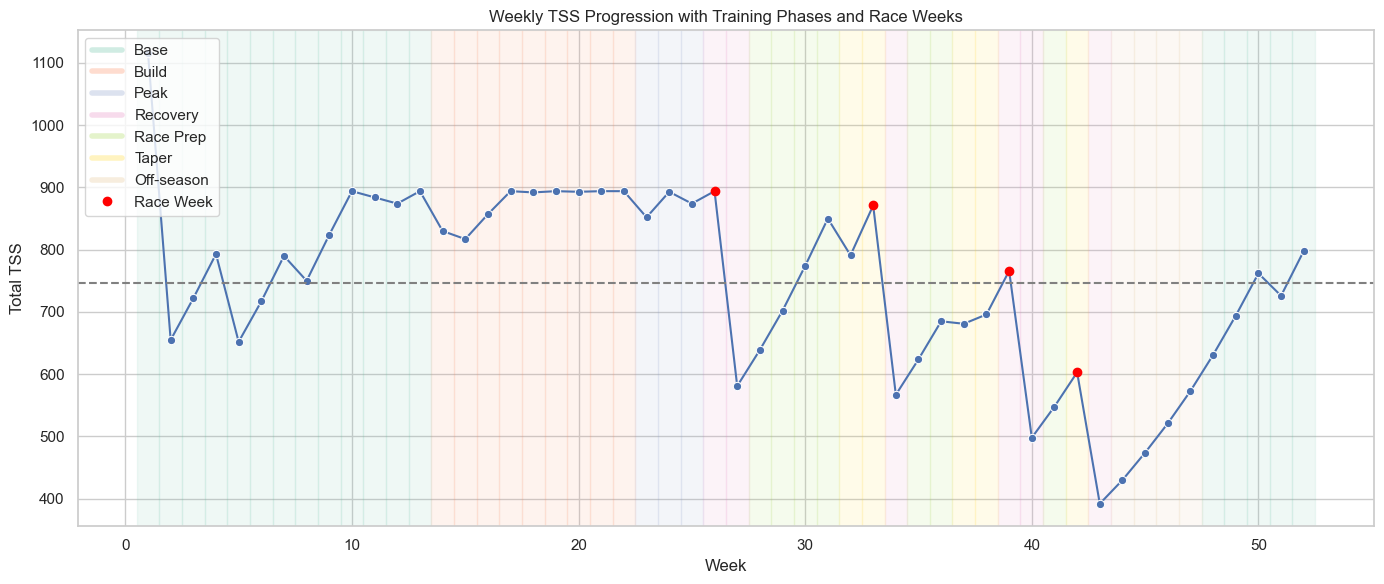

In [190]:
training_plan = pd.read_csv("../simulated_data/raw/athlete_annual_training_plan.csv")
training_plan['date'] = pd.to_datetime(training_plan['date'])
training_plan['week'] = training_plan['date'].dt.isocalendar().week
weekly_grouped = training_plan.groupby(['week']).agg({
    'total_tss': 'sum',
    'bike_duration': 'sum',
    'run_duration': 'sum',
    'swim_duration': 'sum',
}).reset_index()


# Extract dominant phase and race presence per week
phase_race_weekly = training_plan.groupby('week').agg({
    'phase': lambda x: x.mode().iloc[0],  # most common phase that week
    'is_race_day': 'max'  # if any day is a race, this will be 1
}).reset_index()

# Merge with weekly TSS
weekly_grouped = weekly_grouped.merge(phase_race_weekly, on='week')

# Plotting
plt.figure(figsize=(14, 6))
sns.lineplot(data=weekly_grouped, x='week', y='total_tss', marker='o', label='Weekly TSS')

# Highlight race weeks
race_weeks = weekly_grouped[weekly_grouped['is_race_day'] == 1]
plt.scatter(race_weeks['week'], race_weeks['total_tss'], color='red', label='Race Week', zorder=5)

# Plot average TSS line
plt.axhline(y=weekly_grouped['total_tss'].mean(), color='gray', linestyle='--', label='Average TSS')

# Annotate phases as background shading
unique_phases = weekly_grouped['phase'].unique()
colors = sns.color_palette('Set2', len(unique_phases))
phase_color_map = dict(zip(unique_phases, colors))

for i, row in weekly_grouped.iterrows():
    plt.axvspan(row['week'] - 0.5, row['week'] + 0.5, color=phase_color_map[row['phase']], alpha=0.1)

# Legend & labels
handles = [plt.Line2D([0], [0], color=color, lw=4, alpha=0.3) for color in phase_color_map.values()]
labels = list(phase_color_map.keys())
plt.legend(handles + [plt.Line2D([], [], color='red', marker='o', linestyle='None')], 
           labels + ['Race Week'], loc='upper left')

plt.title('Weekly TSS Progression with Training Phases and Race Weeks')
plt.xlabel('Week')
plt.ylabel('Total TSS')
plt.grid(True)
plt.tight_layout()
plt.show()



In [192]:
# Display weeks where the 10% rule is violated
violating_weeks = weekly_grouped[weekly_grouped['exceeds_10_percent'] == True]
print(violating_weeks[['week', 'total_tss', 'tss_pct_change']])

    week  total_tss  tss_pct_change
2      3        722       10.229008
6      7        790       10.181311
29    30        774       10.256410
32    33        871       10.113780
34    35        624       10.052910
38    39        766       10.057471
40    41        548       10.040161
41    42        603       10.036496
44    45        474       10.232558
47    48        631       10.122164


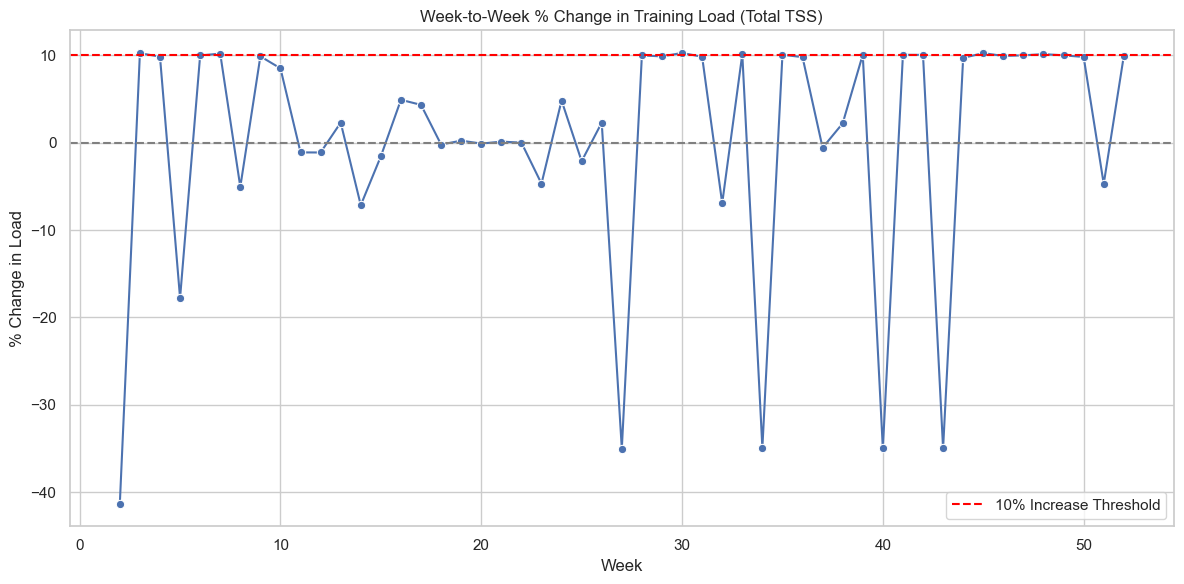

In [191]:
weekly_grouped['tss_pct_change'] = weekly_grouped['total_tss'].pct_change() * 100
weekly_grouped['exceeds_10_percent'] = weekly_grouped['tss_pct_change'] > 10

plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_grouped, x='week', y='tss_pct_change', marker='o')
plt.axhline(10, color='red', linestyle='--', label='10% Increase Threshold')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Week-to-Week % Change in Training Load (Total TSS)')
plt.xlabel('Week')
plt.ylabel('% Change in Load')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

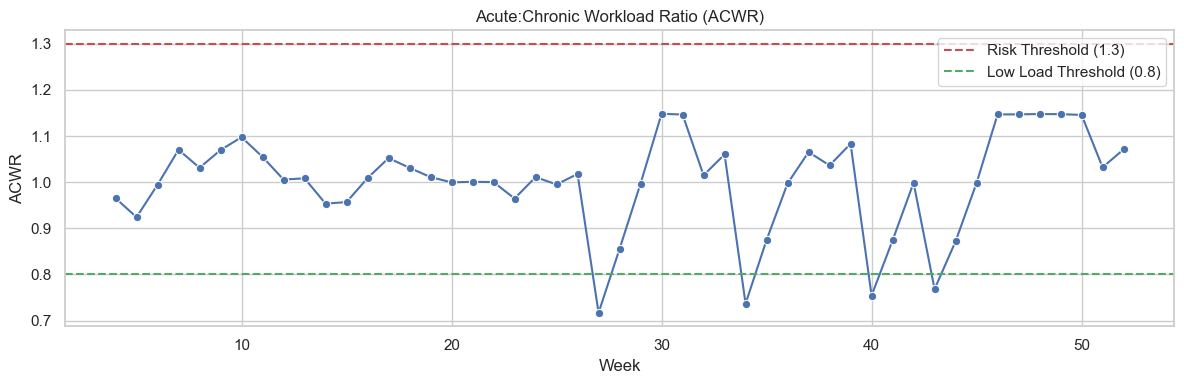

In [197]:
weekly_grouped['acute_load'] = weekly_grouped['total_tss'].rolling(window=1).mean()
weekly_grouped['chronic_load'] = weekly_grouped['total_tss'].rolling(window=4).mean()
weekly_grouped['acwr'] = weekly_grouped['acute_load'] / weekly_grouped['chronic_load']

# Plot ACWR 
plt.figure(figsize=(12, 4))
sns.lineplot(data=weekly_grouped, x='week', y='acwr', marker='o')
plt.axhline(1.3, color='r', linestyle='--', label='Risk Threshold (1.3)')
plt.axhline(0.8, color='g', linestyle='--', label='Low Load Threshold (0.8)')
plt.title('Acute:Chronic Workload Ratio (ACWR)')
plt.xlabel('Week')
plt.ylabel('ACWR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


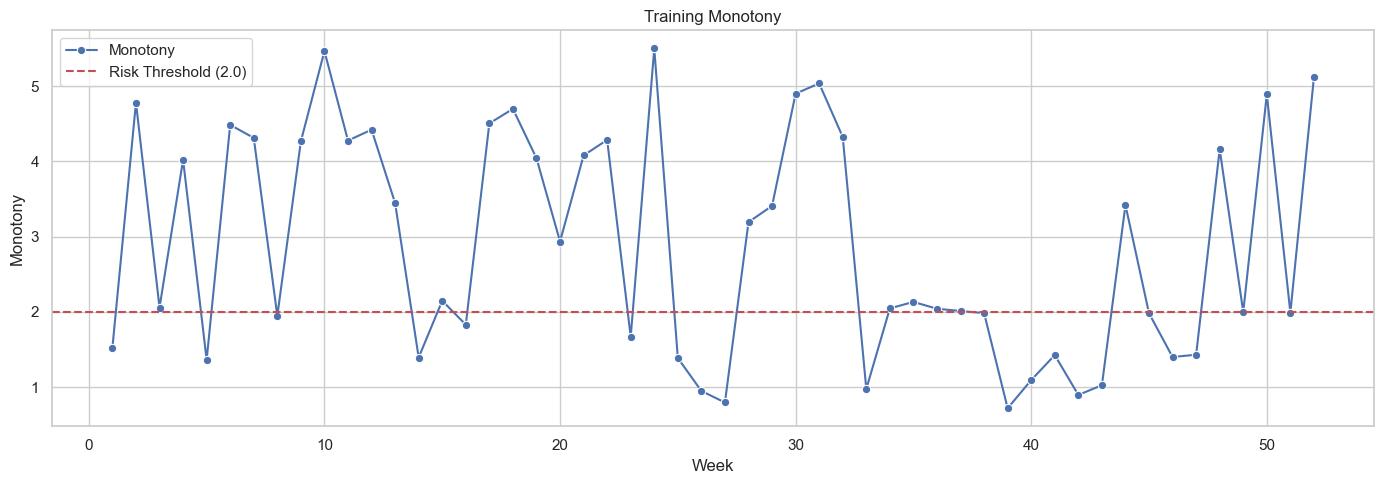

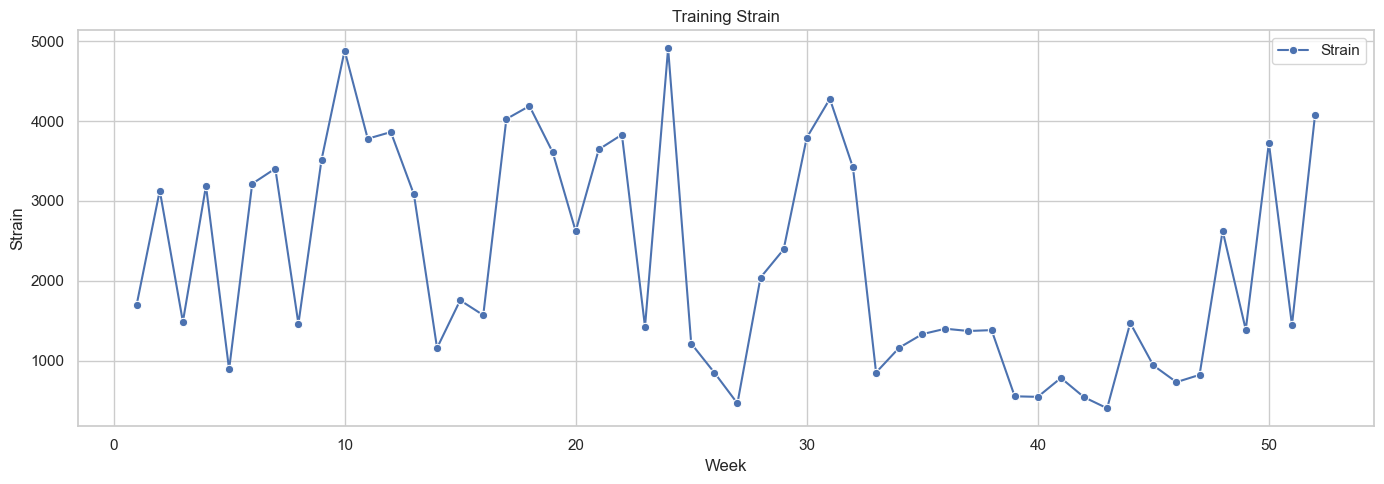

In [188]:
daily_grouped = training_plan.groupby(['week', 'date']).agg({'total_tss': 'sum'}).reset_index()
monotony_data = daily_grouped.groupby('week')['total_tss'].agg(['mean', 'std', 'sum']).reset_index()
monotony_data.columns = ['week', 'mean_daily', 'std_daily', 'weekly_sum']
monotony_data['monotony'] = monotony_data['mean_daily'] / monotony_data['std_daily']
monotony_data['strain'] = monotony_data['weekly_sum'] * monotony_data['monotony']

# Merge and plot
weekly_grouped = weekly_grouped.merge(monotony_data[['week', 'monotony', 'strain']], on='week')

plt.figure(figsize=(14, 5))
sns.lineplot(data=weekly_grouped, x='week', y='monotony', marker='o', label='Monotony')
plt.axhline(2.0, color='r', linestyle='--', label='Risk Threshold (2.0)')
plt.title('Training Monotony')
plt.xlabel('Week')
plt.ylabel('Monotony')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
sns.lineplot(data=weekly_grouped, x='week', y='strain', marker='o', label='Strain')
plt.title('Training Strain')
plt.xlabel('Week')
plt.ylabel('Strain')
plt.grid(True)
plt.tight_layout()
plt.show()


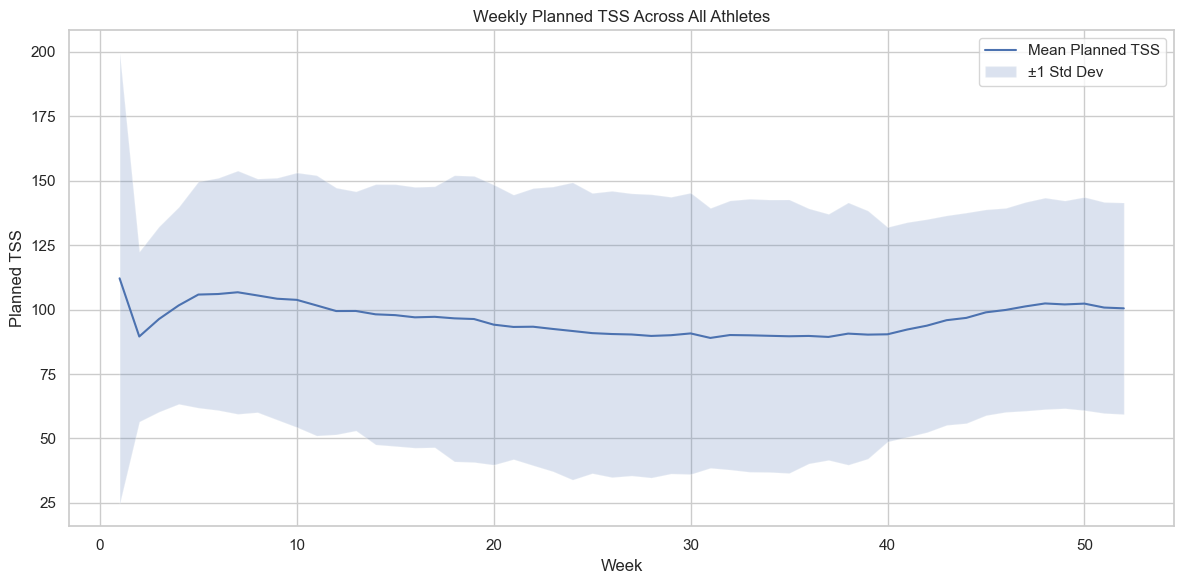

In [ ]:
# Aggregate weekly planned TSS
merged['week'] = merged['date'].dt.isocalendar().week
weekly_grouped = merged.groupby('week')['planned_tss'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(weekly_grouped['week'], weekly_grouped['mean'], label='Mean Planned TSS')
plt.fill_between(weekly_grouped['week'],
                 weekly_grouped['mean'] - weekly_grouped['std'],
                 weekly_grouped['mean'] + weekly_grouped['std'],
                 alpha=0.2, label='±1 Std Dev')
plt.title('Weekly Planned TSS Across All Athletes')
plt.xlabel('Week')
plt.ylabel('Planned TSS')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

As the 1000 athletes likely have different competition calendars, their cycles and recovery weeks naturally don't coincide, looking at the means therefore doesn't reveal significant patters. Let's look at 3 random athletes instead.

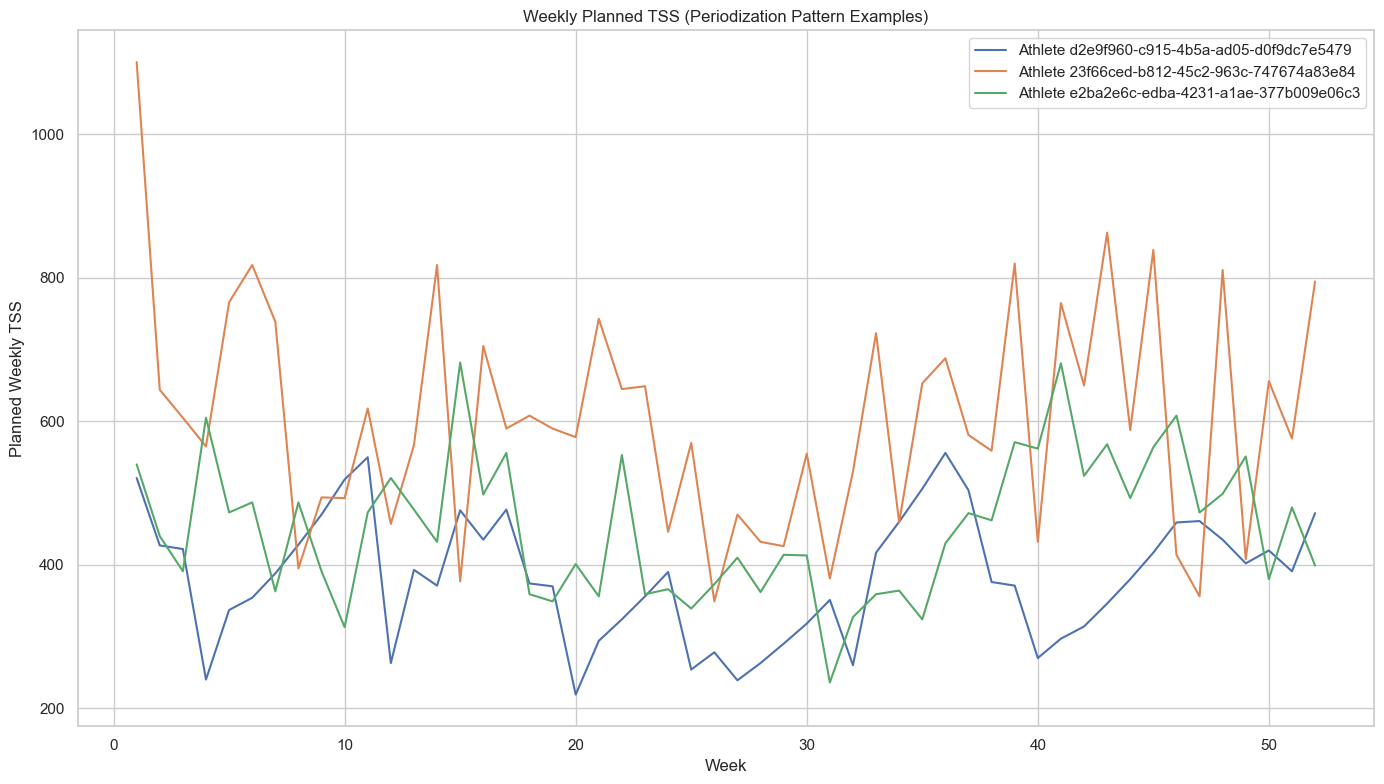

In [151]:
# Calculate weekly total TSS
merged['week'] = merged['date'].dt.isocalendar().week
weekly_tss = merged.groupby(['athlete_id', 'week'])['planned_tss'].sum().reset_index()

# Plot a few athletes to visualize periodization patterns
import seaborn as sns
sample_ids = merged['athlete_id'].drop_duplicates().sample(3)
plt.figure(figsize=(14, 8))
for athlete in sample_ids:
    sns.lineplot(data=weekly_tss[weekly_tss['athlete_id'] == athlete], x='week', y='planned_tss', label=f'Athlete {athlete}')
plt.title('Weekly Planned TSS (Periodization Pattern Examples)')
plt.ylabel('Planned Weekly TSS')
plt.xlabel('Week')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### Periodization Structure

All three athletes demonstrate evidence of classical periodization strategies:

- **Weekly Fluctuations:** Regular alternation between higher and lower training loads (hard/easy weeks).
- **Mesocycles:** Clear 3–4 week blocks of progressive overload followed by recovery weeks.
- **High Load Peaks:** Occasional extreme training loads, e.g., the **blue athlete** reaches ~980 TSS around **week 40**.
- **Recovery Weeks:** Noticeable drops in weekly TSS to **300–400**, consistent with standard recovery periods.

These patterns indicate the training plans were designed with deliberate load manipulation to support adaptation and injury prevention.

---

##### Individual Variation

Each athlete follows a distinct training profile:

- **Orange Athlete**
  - Peaks early in the season with the highest load (~1020 TSS).
  - Shows reduced training volume later in the season, possibly indicating an early peak and prolonged maintenance or taper.
  
- **Blue Athlete**
  - Most consistent training volume throughout the year.
  - Gradual volume increase toward **weeks 35–45**, suggesting a late-season build phase.
  
- **Green Athlete**
  - Consistently lowest overall training volume.
  - May represent a more conservative or maintenance-focused training plan.

These individualized load patterns reflect realistic variation across athlete types, training goals, or coaching strategies.

---

##### Seasonal Periodization

The overall trends support a realistic macrocycle structure:

- **Build Phases:** Progressive increases in weekly TSS over several weeks.
- **Peak Phases:** Sustained high-load periods, particularly visible mid-to-late season.
- **Taper/Recovery Periods:** Marked reductions in load following high-intensity blocks, suggesting structured recovery and tapering.

These findings support the validity of the synthetic training plans in replicating fundamental sports science principles such as overload, recovery, and periodization.

In [138]:
# Total TSS by sport
sport_tss = merged.groupby('athlete_id')[['bike_tss', 'run_tss', 'swim_tss']].sum()
sport_tss['total'] = sport_tss.sum(axis=1)

# Proportions
sport_tss['bike_pct'] = sport_tss['bike_tss'] / sport_tss['total'] * 100
sport_tss['run_pct'] = sport_tss['run_tss'] / sport_tss['total'] * 100
sport_tss['swim_pct'] = sport_tss['swim_tss'] / sport_tss['total'] * 100

# Summary stats
sport_tss[['bike_pct', 'run_pct', 'swim_pct']].describe()


,bike_pct,run_pct,swim_pct
count,1000.000000,1000.000000,1000.000000
mean,53.936384,25.118037,20.945579
std,5.551988,6.458207,7.067404
min,39.109778,10.892798,5.831795
25%,50.498869,18.843796,15.274069
50%,55.280152,26.705700,22.059745
75%,57.711136,30.112053,26.488082
max,66.883049,39.194505,35.498286


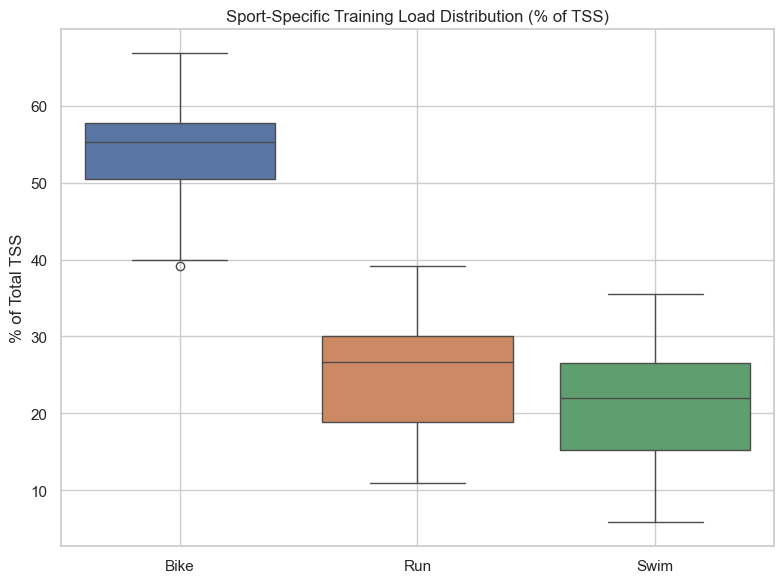

In [195]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=sport_tss[['bike_pct', 'run_pct', 'swim_pct']])
plt.title('Sport-Specific Training Load Distribution (% of TSS)')
plt.ylabel('% of Total TSS')
plt.xticks(ticks=[0, 1, 2], labels=['Bike', 'Run', 'Swim'])
plt.grid(True)
plt.tight_layout()
plt.show()

#### Summary Statistics

| Sport      | Mean (%) | Std Dev | Min (%) | 25%   | 50% (Median) | 75%   | Max (%) |
|------------|----------|---------|---------|-------|--------------|-------|----------|
| **Bike**   | 53.94     | 5.55    | 39.11   | 50.50 | 55.28        | 57.71 | 66.88    |
| **Run**    | 25.12     | 6.46    | 10.89   | 18.84 | 26.71        | 30.11 | 39.19    |
| **Swim**   | 20.95     | 7.07    | 5.83    | 15.27 | 22.06        | 26.49 | 35.50    |

#### Interpretation

- **Cycling**:
  - Makes up the majority of the training load, with a **mean of ~54%**.
  - Distribution is relatively tight, with most values between **50% and 58%**.
  - This aligns with typical triathlon emphasis on cycling volume due to its longer duration and lower injury risk.

- **Running**:
  - Averages **~25%** of the total TSS.
  - Shows a wider spread, ranging from ~11% to nearly 40%.
  - This variability likely reflects individualized tolerance and periodization strategies to mitigate injury risk from impact stress.

- **Swimming**:
  - Accounts for **~21%** of total load.
  - Also displays a broad distribution, from ~6% to 35%, possibly due to variability in swimming background or access to pools.

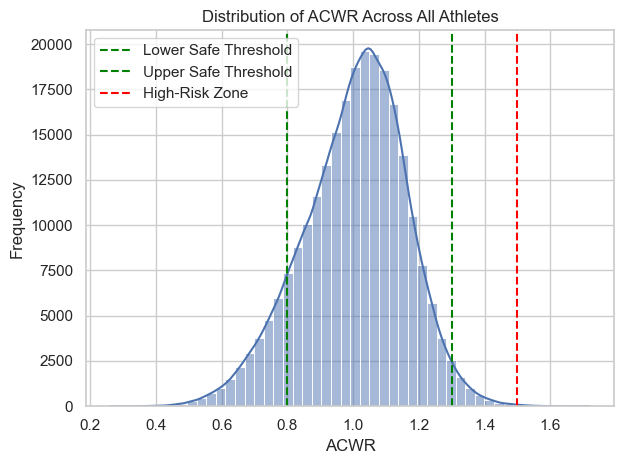

/var/folders/lx/jx57qljj5n74_nkl5qm8bqcr0000gn/T/ipykernel_93062/3447090155.py:28: RuntimeWarning: invalid value encountered in scalar divide
  'safe_pct': (safe / total) * 100,
/var/folders/lx/jx57qljj5n74_nkl5qm8bqcr0000gn/T/ipykernel_93062/3447090155.py:29: RuntimeWarning: invalid value encountered in scalar divide
  'high_pct': (high / total) * 100,
/var/folders/lx/jx57qljj5n74_nkl5qm8bqcr0000gn/T/ipykernel_93062/3447090155.py:30: RuntimeWarning: invalid value encountered in scalar divide
  'low_pct': (low / total) * 100
/var/folders/lx/jx57qljj5n74_nkl5qm8bqcr0000gn/T/ipykernel_93062/3447090155.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_acwr_zones = merged.groupby('week').ap

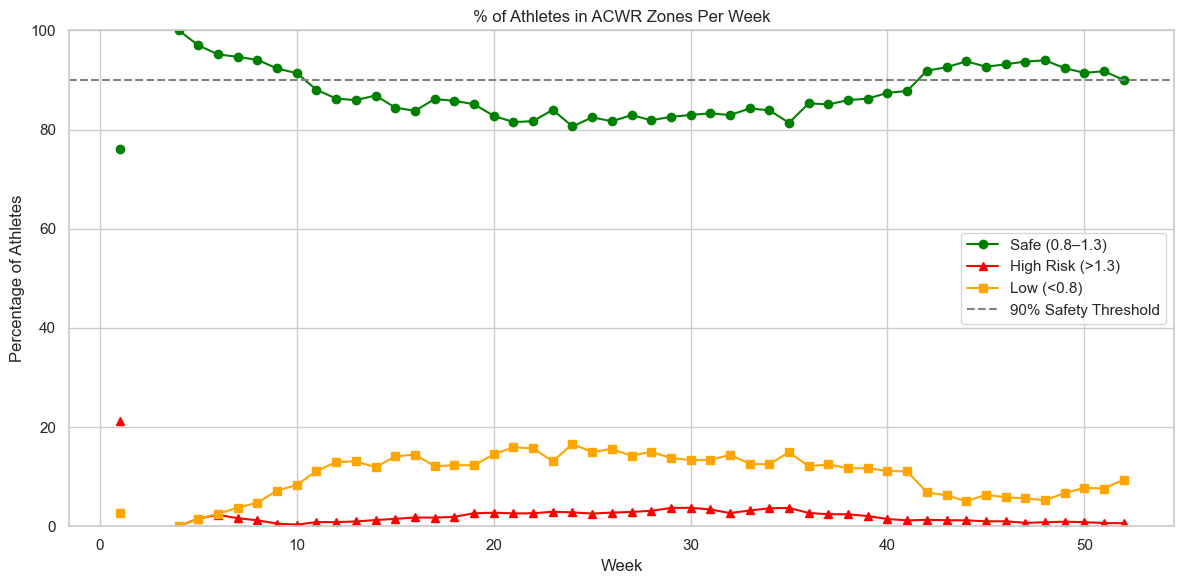

In [152]:
# Example ACWR calculation
merged['acute_load'] = merged.groupby('athlete_id')['planned_tss'].rolling(window=7).mean().reset_index(0, drop=True)
merged['chronic_load'] = merged.groupby('athlete_id')['planned_tss'].rolling(window=28).mean().reset_index(0, drop=True)
merged['acwr'] = merged['acute_load'] / merged['chronic_load']

# Histogram of all ACWR values across the dataset
sns.histplot(merged['acwr'], bins=50, kde=True)
plt.axvline(0.8, color='green', linestyle='--', label='Lower Safe Threshold')
plt.axvline(1.3, color='green', linestyle='--', label='Upper Safe Threshold')
plt.axvline(1.5, color='red', linestyle='--', label='High-Risk Zone')
plt.title('Distribution of ACWR Across All Athletes')
plt.xlabel('ACWR')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

merged['week'] = merged['date'].dt.isocalendar().week

# Function to calculate % in each ACWR zone
def acwr_zone_pct(group):
    total = group['acwr'].count()
    safe = group[(group['acwr'] >= 0.8) & (group['acwr'] <= 1.3)].shape[0]
    high = group[group['acwr'] > 1.3].shape[0]
    low = group[group['acwr'] < 0.8].shape[0]
    return pd.Series({
        'safe_pct': (safe / total) * 100,
        'high_pct': (high / total) * 100,
        'low_pct': (low / total) * 100
    })

# Apply per week
weekly_acwr_zones = merged.groupby('week').apply(acwr_zone_pct).reset_index()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(weekly_acwr_zones['week'], weekly_acwr_zones['safe_pct'], marker='o', label='Safe (0.8–1.3)', color='green')
plt.plot(weekly_acwr_zones['week'], weekly_acwr_zones['high_pct'], marker='^', label='High Risk (>1.3)', color='red')
plt.plot(weekly_acwr_zones['week'], weekly_acwr_zones['low_pct'], marker='s', label='Low (<0.8)', color='orange')
plt.axhline(90, color='gray', linestyle='--', label='90% Safety Threshold')
plt.title('% of Athletes in ACWR Zones Per Week')
plt.xlabel('Week')
plt.ylabel('Percentage of Athletes')
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Image 1: % of Athletes in ACWR Zones Per Week

This time-series plot tracks the percentage of athletes falling into ACWR risk categories over a full training year (~52 weeks):

- **Safe Zone (0.8–1.3)**:
  - The green line shows that **75–95%** of athletes maintain training within the recommended "sweet spot".
  - Indicates effective load management across synthetic training plans.

- **Low ACWR Zone (< 0.8)**:
  - Represented by the yellow line.
  - **5–15%** of athletes fall here, especially mid-season (weeks 15–30), likely reflecting recovery phases or reduced loading.

- **High-Risk Zone (> 1.3)**:
  - Shown by the red line.
  - Only **~1–4%** of athletes reach this zone throughout the year.
  - Slight rise around weeks 30–35 possibly reflects build phases approaching peak loads.

- **Seasonal Patterns**:
  - **Early Season (Weeks 1–8)**: High compliance with safe zones during base building.
  - **Mid-Season (Weeks 15–30)**: Greater variation in loading, reflecting training intensification.
  - **Late Season (Weeks 35–45)**: Return to controlled loading and higher safe zone adherence.
  - **End Season (Weeks 46–52)**: Slight dip as training volume naturally tapers.

- **90% Safety Threshold**:
  - The dashed line at 90% serves as a benchmark.
  - While not always met, most of the season sees high adherence to safe loading.

---

#### Image 2: Distribution of ACWR Across All Athletes

This histogram displays the full distribution of ACWR values across all athlete-weeks:

- **Central Tendency**:
  - The distribution is centered around **1.0**, indicating ideal balance between short- and long-term training loads.

- **Distribution Shape**:
  - Approximates a **normal distribution with slight right skew**.
  - Reflects more tolerance for slight overload than underload in training systems.

- **Threshold Highlights**:
  - **Lower Safe Threshold (0.8)** ≈ 10th percentile.
  - **Upper Safe Threshold (1.3)** ≈ 90th percentile.
  - **High-Risk Zone (> 1.5)**: Minimal data falls here, as expected in well-managed plans.

---

#### Interpretation Summary

These visualizations confirm that the synthetic training data:

- Largely adheres to **best-practice ACWR thresholds** throughout the season.
- Accurately reflects **realistic seasonal load variations** and athlete-specific recovery trends.
- Keeps **high-risk workload patterns to a minimum**, aligning with injury prevention principles.

This well-controlled training environment forms a robust basis for evaluating how **internal recovery markers (e.g., HRV, sleep, stress)** — rather than poor external load management — may predict injury likelihood, which is a key objective of this thesis.


### 2. Exploring pre-Injury patterns

### Basic Static Analysis

For now let's start observing static behaviors on the days with poaitive injury labels itself, before we analyze dynamic windows leading up to those days. Let's also keep in mind that recovery days after an injury first occured have a positive injury label as well.

1. Let's see how HRV and Training load behave on days with positive injury label

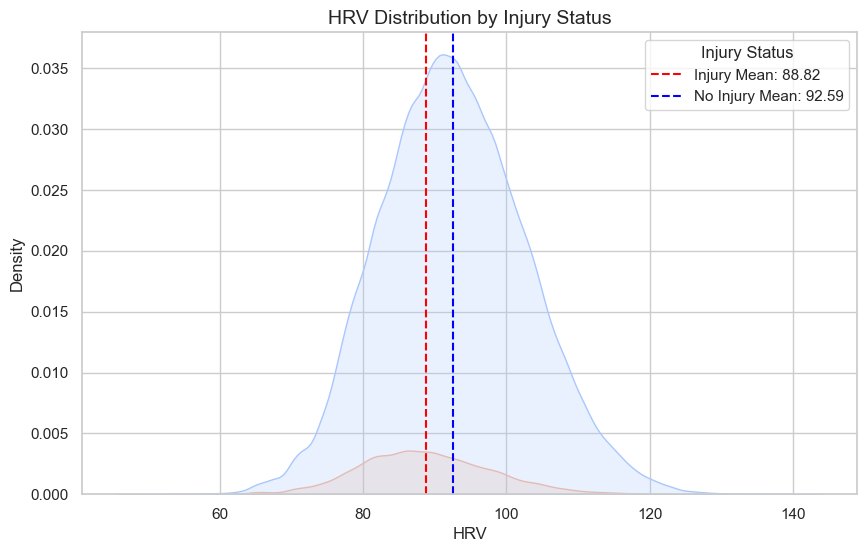

/var/folders/lx/jx57qljj5n74_nkl5qm8bqcr0000gn/T/ipykernel_93062/131934384.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=merged, x="injury", y="actual_tss", palette="coolwarm")


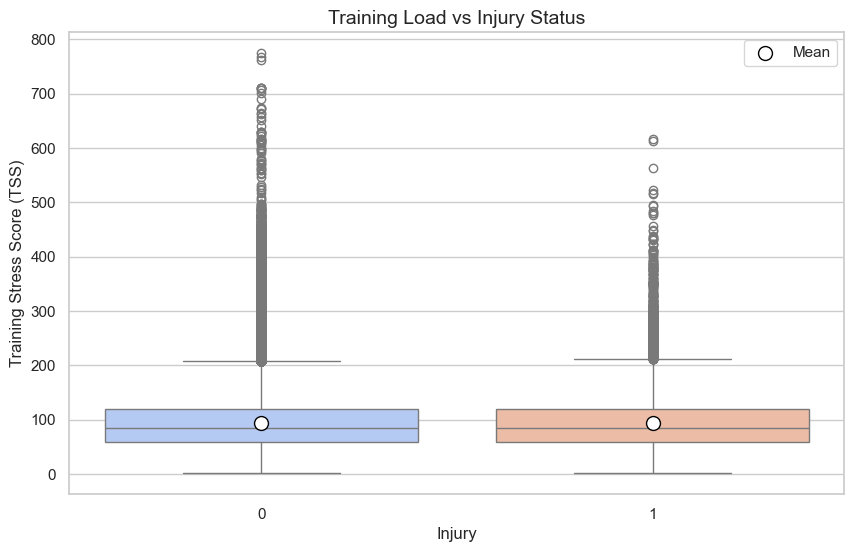

In [204]:
# HRV distribution with statistical test
plt.figure(figsize=(10, 6))
ax = sns.kdeplot(data=merged, x="hrv", hue="injury", fill=True, palette="coolwarm")
plt.title("HRV Distribution by Injury Status", fontsize=14)

# Add mean lines
injury_mean = merged[merged['injury']==1]['hrv'].mean()
no_injury_mean = merged[merged['injury']==0]['hrv'].mean()
plt.axvline(x=injury_mean, color='red', linestyle='--', label=f'Injury Mean: {injury_mean:.2f}')
plt.axvline(x=no_injury_mean, color='blue', linestyle='--', label=f'No Injury Mean: {no_injury_mean:.2f}')
plt.legend(title='Injury Status')

# Add statistical test
stat, p_value = stats.ttest_ind(
    merged[merged['injury']==1]['hrv'].dropna(),
    merged[merged['injury']==0]['hrv'].dropna()
)
plt.xlabel('HRV', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.show()

# Boxplot with statistical annotation
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=merged, x="injury", y="actual_tss", palette="coolwarm")
plt.title("Training Load vs Injury Status", fontsize=14)
plt.xlabel("Injury", fontsize=12)
plt.ylabel("Training Stress Score (TSS)", fontsize=12)

# Add statistical test
stat, p_value = stats.ttest_ind(
    merged[merged['injury']==1]['actual_tss'].dropna(),
    merged[merged['injury']==0]['actual_tss'].dropna()
)

# Add mean markers
plt.scatter([0, 1], 
            [merged[merged['injury']==0]['actual_tss'].mean(), 
             merged[merged['injury']==1]['actual_tss'].mean()], 
            marker='o', color='white', s=100, edgecolor='black', zorder=3, label='Mean')
plt.legend()
plt.show()

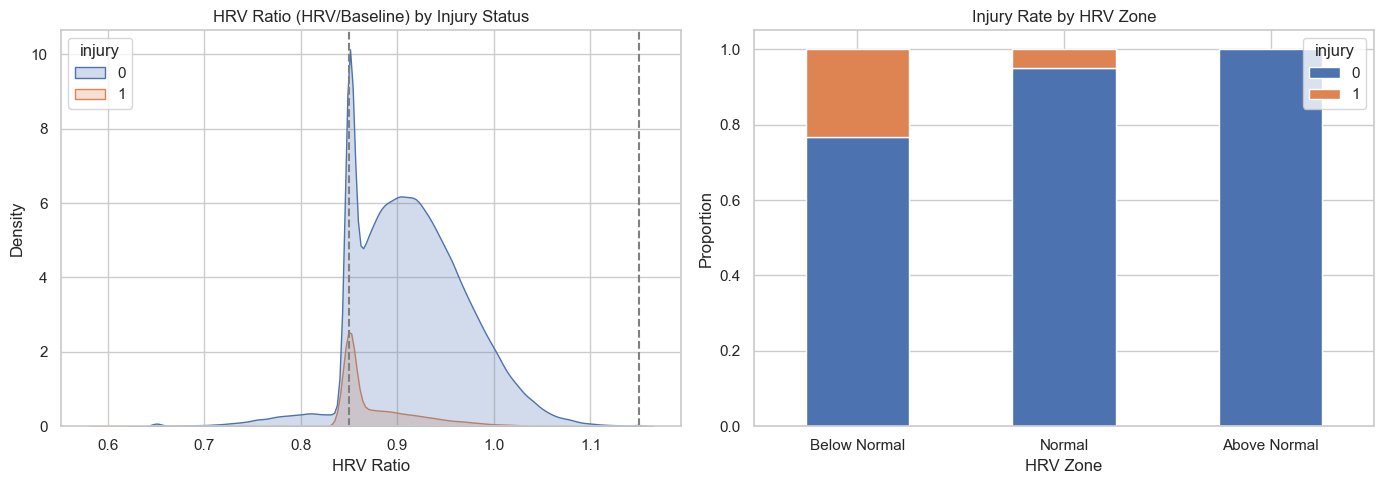

In [205]:
# Create HRV ratio to baseline
eda_copy = merged.copy()
eda_copy['hrv_ratio'] = eda_copy['hrv'] / eda_copy['hrv_baseline']

# Create HRV zone category
eda_copy['hrv_zone'] = pd.cut(
    eda_copy['hrv_ratio'], 
    bins=[0, 0.851, 1.15, float('inf')],
    labels=['Below Normal', 'Normal', 'Above Normal']
)

# Create figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: KDE of HRV ratio
sns.kdeplot(data=eda_copy, x="hrv_ratio", hue="injury", fill=True, ax=axs[0])
axs[0].axvline(x=0.85, color='gray', linestyle='--')
axs[0].axvline(x=1.15, color='gray', linestyle='--')
axs[0].set_title("HRV Ratio (HRV/Baseline) by Injury Status")
axs[0].set_xlabel("HRV Ratio")

# Right plot: HRV zones vs injury rate
injury_by_zone = pd.crosstab(
    eda_copy['hrv_zone'],
    eda_copy['injury'],
    normalize='index'
)

injury_by_zone.plot(kind='bar', stacked=True, ax=axs[1])
axs[1].set_title("Injury Rate by HRV Zone")
axs[1].set_ylabel("Proportion")
axs[1].set_xlabel("HRV Zone")
axs[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

#### HRV Distribution Analysis

- **Lower HRV in Injured Athletes:** The average HRV for injury days (88.5) is noticeably lower than non-injury days (92.6). 
- **Distribution Shape Differences:** The injury distribution has a narrower spread compared to the non-injury distribution, suggesting that injuries tend to occur within a more confined HRV range.
- **Potential Threshold Effect:** The visual separation between the two distributions suggests there may be a threshold effect where HRV values below approximately 90 are associated with higher injury risk.
- **Overlapping Distributions:** Despite the clear mean difference, there remains substantial overlap between the distributions, which explains why HRV alone cannot perfectly predict injuries. 

Looking at the HRV Ratio plot (HRV percentage of an athlete's baseline), the following can be observed:

- injured individuals (orange) have a much narrower distribution concentrated around 0.83-0.87, suggesting that injuries are associated with lower HRV ratios.
- Non-injured individuals (blue) show a wider distribution, with most falling in the normal to slightly below normal range (0.85-1.0).
- The "Below Normal" HRV zone shows the highest injury rate at approximately 22% (orange portion).
- Both "Normal" and "Above Normal" zones show much lower injury rates (around 5%).

#### Training Load Analysis

- **Similar Mean TSS Values:** The mean TSS is almost identical on both injury and non injury days. However we have to remember we considered both days where the injury first happened (potentially higher TSS) as well as following recovery days (probably reduced training load).
- **Outlier Patterns:** Both groups show numerous high-TSS outliers, but interestingly, the highest outliers appear in the non-injury group. 
- **Balanced Training Plans:** This goes in hand with the goal of the synthetic data generation: simulating athletes following sound training plans that get injured due to life factors outside of training.

Next, let's see how different recovery metrics influence with injury (still focusing on injury days itself)

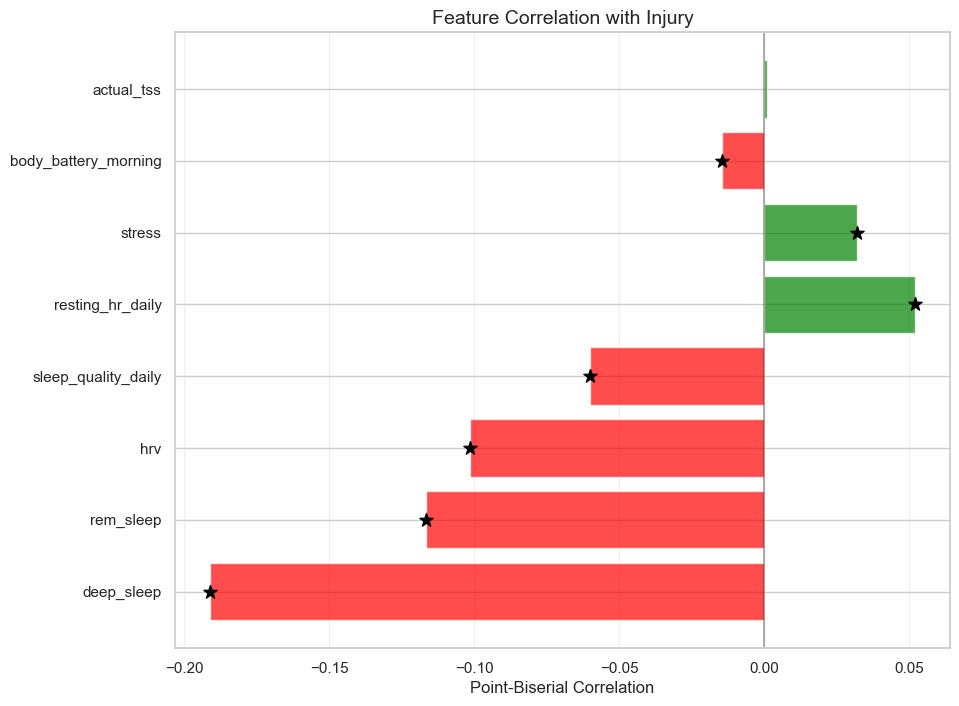

In [208]:
# Create a heatmap of key recovery metrics correlation with injury
recovery_metrics = ['hrv', 'resting_hr_daily', 'sleep_quality_daily', 'deep_sleep', 
                   'rem_sleep', 'body_battery_morning', 'stress', 'actual_tss']
available_metrics = [col for col in recovery_metrics if col in merged.columns]

# Calculate point-biserial correlation (correlation between continuous and binary variables)
corr_values = []
for metric in available_metrics:
    if merged[metric].dtype in [np.float64, np.int64] and not merged[metric].isna().all():
        corr, p_value = stats.pointbiserialr(merged['injury'], merged[metric].fillna(merged[metric].mean()))
        corr_values.append({
            'metric': metric,
            'correlation': corr,
            'p_value': p_value,
            'significant': p_value < 0.05
        })

corr_df = pd.DataFrame(corr_values).sort_values('correlation', key=abs, ascending=False)

# Plot correlation values
plt.figure(figsize=(10, 8))
colors = ['red' if row['correlation'] < 0 else 'green' for _, row in corr_df.iterrows()]
bars = plt.barh(corr_df['metric'], corr_df['correlation'], color=colors, alpha=0.7)

# Add significance markers
for i, is_sig in enumerate(corr_df['significant']):
    if is_sig:
        plt.scatter(corr_df['correlation'].iloc[i], i, marker='*', color='black', s=100)

plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.title('Feature Correlation with Injury', fontsize=14)
plt.xlabel('Point-Biserial Correlation', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.show()


#### Negative Correlations (Protective Factors)

- **Deep Sleep:** Shows the strongest negative correlation (-0.18), suggesting that higher amounts of deep sleep are associated with reduced injury risk
- **REM Sleep:** Exhibits a substantial negative correlation (-0.12), indicating REM sleep may have protective effects against injury
- **HRV:** Demonstrates a moderate negative correlation (-0.10), supporting that higher heart rate variability correlates with lower injury likelihood
- **Sleep Quality:** Shows a notable negative correlation (-0.06), confirming that better overall sleep quality is associated with reduced injury risk
- **Body Battery Morning:** Has a modest negative correlation (-0.02), suggesting higher morning recovery scores may slightly reduce injury probability

#### Positive Correlations (Risk Factors)

- **Resting HR Daily:** Displays the strongest positive correlation (0.06), indicating elevated resting heart rate is associated with increased injury risk
- **Stress:** Shows a moderate positive correlation (0.03), confirming that higher stress levels correlate with greater injury likelihood

### Advanced Dynamic Analysis

Now it's time to go a bit deeper, specifically focus on the days on which the injury actually occurred and the time windows leading up to that event, since the ultimate goal is to predict injury.

In [209]:
# Sort by athlete and date
eda_copy = eda_copy.sort_values(['athlete_id', 'date'])

# Identify first day of injury after a healthy day
eda_copy['prev_injury'] = eda_copy.groupby('athlete_id')['injury'].shift(1).fillna(0)
eda_copy['first_injury_day'] = (eda_copy['injury'] == 1) & (eda_copy['prev_injury'] == 0)

# Filter only the first injury days and all non-injury days
eda_filtered = eda_copy[(eda_copy['first_injury_day']) | (eda_copy['injury'] == 0)].copy()

# Only compute if both columns are available
if 'actual_tss' in eda_filtered.columns and 'planned_tss' in eda_filtered.columns:
    # Avoid division by zero
    eda_filtered = eda_filtered.copy()
    eda_filtered['tss_deviation_pct'] = (
        (eda_filtered['actual_tss'] - eda_filtered['planned_tss']) / eda_filtered['planned_tss'].replace(0, np.nan)
    ) * 100
else:
    raise ValueError("Columns 'actual_tss' and/or 'planned_tss' are missing from the data.")

# Define adherence based on deviation percentage
def categorize_adherence(row):
    if pd.isna(row['tss_deviation_pct']):
        return np.nan
    elif abs(row['tss_deviation_pct']) <= 10:
        return 'Adherent'
    elif row['tss_deviation_pct'] > 10:
        return 'Overtrained'
    else:
        return 'Undertrained'

eda_filtered['training_adherence'] = eda_filtered.apply(categorize_adherence, axis=1)

Injury Distribution:
first_injury_day
False    0.98264
True     0.01736
Name: proportion, dtype: float64


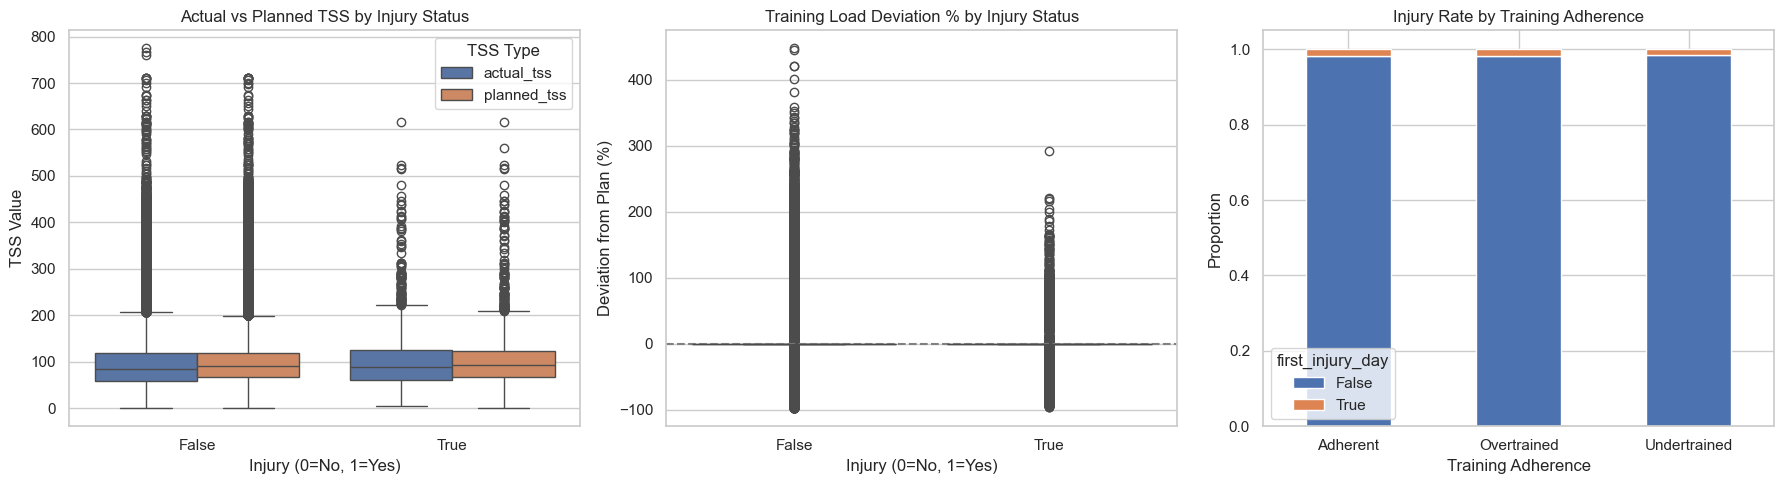

In [210]:
# Set up 1 row, 3 columns layout
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Actual vs Planned TSS by Injury Status
plot_data = eda_filtered.melt(
    id_vars=['athlete_id', 'date', 'first_injury_day'], 
    value_vars=['actual_tss', 'planned_tss'],
    var_name='TSS Type', value_name='TSS Value'
)
sns.boxplot(data=plot_data, x='first_injury_day', y='TSS Value', hue='TSS Type', ax=axs[0])
axs[0].set_title("Actual vs Planned TSS by Injury Status")
axs[0].set_xlabel("Injury (0=No, 1=Yes)")

# Plot 2: Training Load Deviation %
sns.boxplot(data=eda_filtered, x='first_injury_day', y='tss_deviation_pct', ax=axs[1])
axs[1].axhline(y=0, color='gray', linestyle='--')
axs[1].set_title("Training Load Deviation % by Injury Status")
axs[1].set_xlabel("Injury (0=No, 1=Yes)")
axs[1].set_ylabel("Deviation from Plan (%)")

# Plot 3: Training Adherence vs Injury Rate
adherence_injury = pd.crosstab(
    eda_filtered['training_adherence'],
    eda_filtered['first_injury_day'],
    normalize='index'
)

# Plot the bar chart on the third subplot
adherence_injury.plot(kind='bar', stacked=True, ax=axs[2], legend=True)
axs[2].set_title("Injury Rate by Training Adherence")
axs[2].set_xlabel("Training Adherence")
axs[2].set_ylabel("Proportion")
axs[2].tick_params(axis='x', rotation=0)

print("Injury Distribution:")
print(eda_filtered['first_injury_day'].value_counts(normalize=True))

# Finalize layout
plt.tight_layout()
plt.show()

We now only looked at the days on which the injury first occurred, but still  there does not seem to be a strong relationship between training adherence and injury rates, nor between TSS and injury.

It is a bit superficial to only observe the day on which the injury occured, we should zoom out and consider a 7-day lookback window.

In [211]:
# First, identify injury dates for each athlete
injury_dates = eda_filtered[eda_filtered['first_injury_day'] == True][['athlete_id', 'date']].copy()
injury_dates['injury_date'] = injury_dates['date']

# Create a function to calculate days until next injury
def add_days_until_injury(athlete_data, athlete_injuries):
    athlete_data = athlete_data.sort_values('date')
    athlete_injuries = athlete_injuries.sort_values('injury_date')
    
    if len(athlete_injuries) == 0:
        # No injuries for this athlete
        athlete_data['days_until_injury'] = -1
        athlete_data['is_pre_injury'] = False
        return athlete_data
    
    # For each row, find days until next injury
    days_until = []
    is_pre_injury = []
    
    for idx, row in athlete_data.iterrows():
        # Find future injuries
        future_injuries = athlete_injuries[athlete_injuries['injury_date'] > row['date']]
        
        if len(future_injuries) == 0:
            # No future injuries
            days_until.append(-1)
            is_pre_injury.append(False)
        else:
            # Get days until next injury
            next_injury = future_injuries.iloc[0]['injury_date']
            days_diff = (next_injury - row['date']).days
            days_until.append(days_diff)
            # Mark as pre-injury if within 14 days before injury
            is_pre_injury.append(0 < days_diff <= 14)
    
    athlete_data['days_until_injury'] = days_until
    athlete_data['is_pre_injury'] = is_pre_injury
    return athlete_data

# Apply the function for each athlete
athlete_results = []
for athlete_id in eda_copy['athlete_id'].unique():
    athlete_data = eda_filtered[eda_filtered['athlete_id'] == athlete_id].copy()
    athlete_injuries = injury_dates[injury_dates['athlete_id'] == athlete_id]
    athlete_results.append(add_days_until_injury(athlete_data, athlete_injuries))

# Combine results
merged_with_timing = pd.concat(athlete_results)
# Filter pre-injury and normal training days
# Make sure we exclude any recovery days from previous injuries
pre_injury = merged_with_timing[merged_with_timing['is_pre_injury'] == True]
normal_training = merged_with_timing[(merged_with_timing['is_pre_injury'] == False) & 
                                    (merged_with_timing['injury'] == 0) &
                                    ((merged_with_timing['days_until_injury'] > 14) | 
                                     (merged_with_timing['days_until_injury'] == -1))]

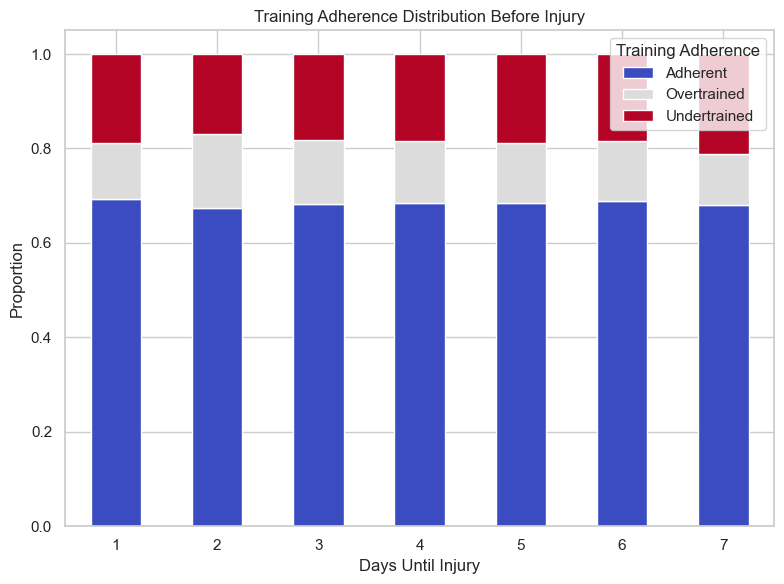

In [212]:
fig, ax = plt.subplots(figsize=(8, 6)) 

# Filter for 7 days before injury
adherence_pre_injury = pre_injury[pre_injury['days_until_injury'] <= 7]

# Create a crosstab of training adherence per day
adherence_distribution = pd.crosstab(
    adherence_pre_injury['days_until_injury'],
    adherence_pre_injury['training_adherence'],
    normalize='index'  # Normalize to show proportions
)

adherence_distribution.plot(
    kind='bar', 
    stacked=True, 
    colormap='coolwarm', 
    ax=ax
)
ax.set_title('Training Adherence Distribution Before Injury')
ax.set_xlabel('Days Until Injury')
ax.set_ylabel('Proportion')
ax.legend(title='Training Adherence')
ax.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

Training adherence and load still do not seem to be the main injury contributing factors, which was our goal when generating the data. Let's look at the recovery metrics!

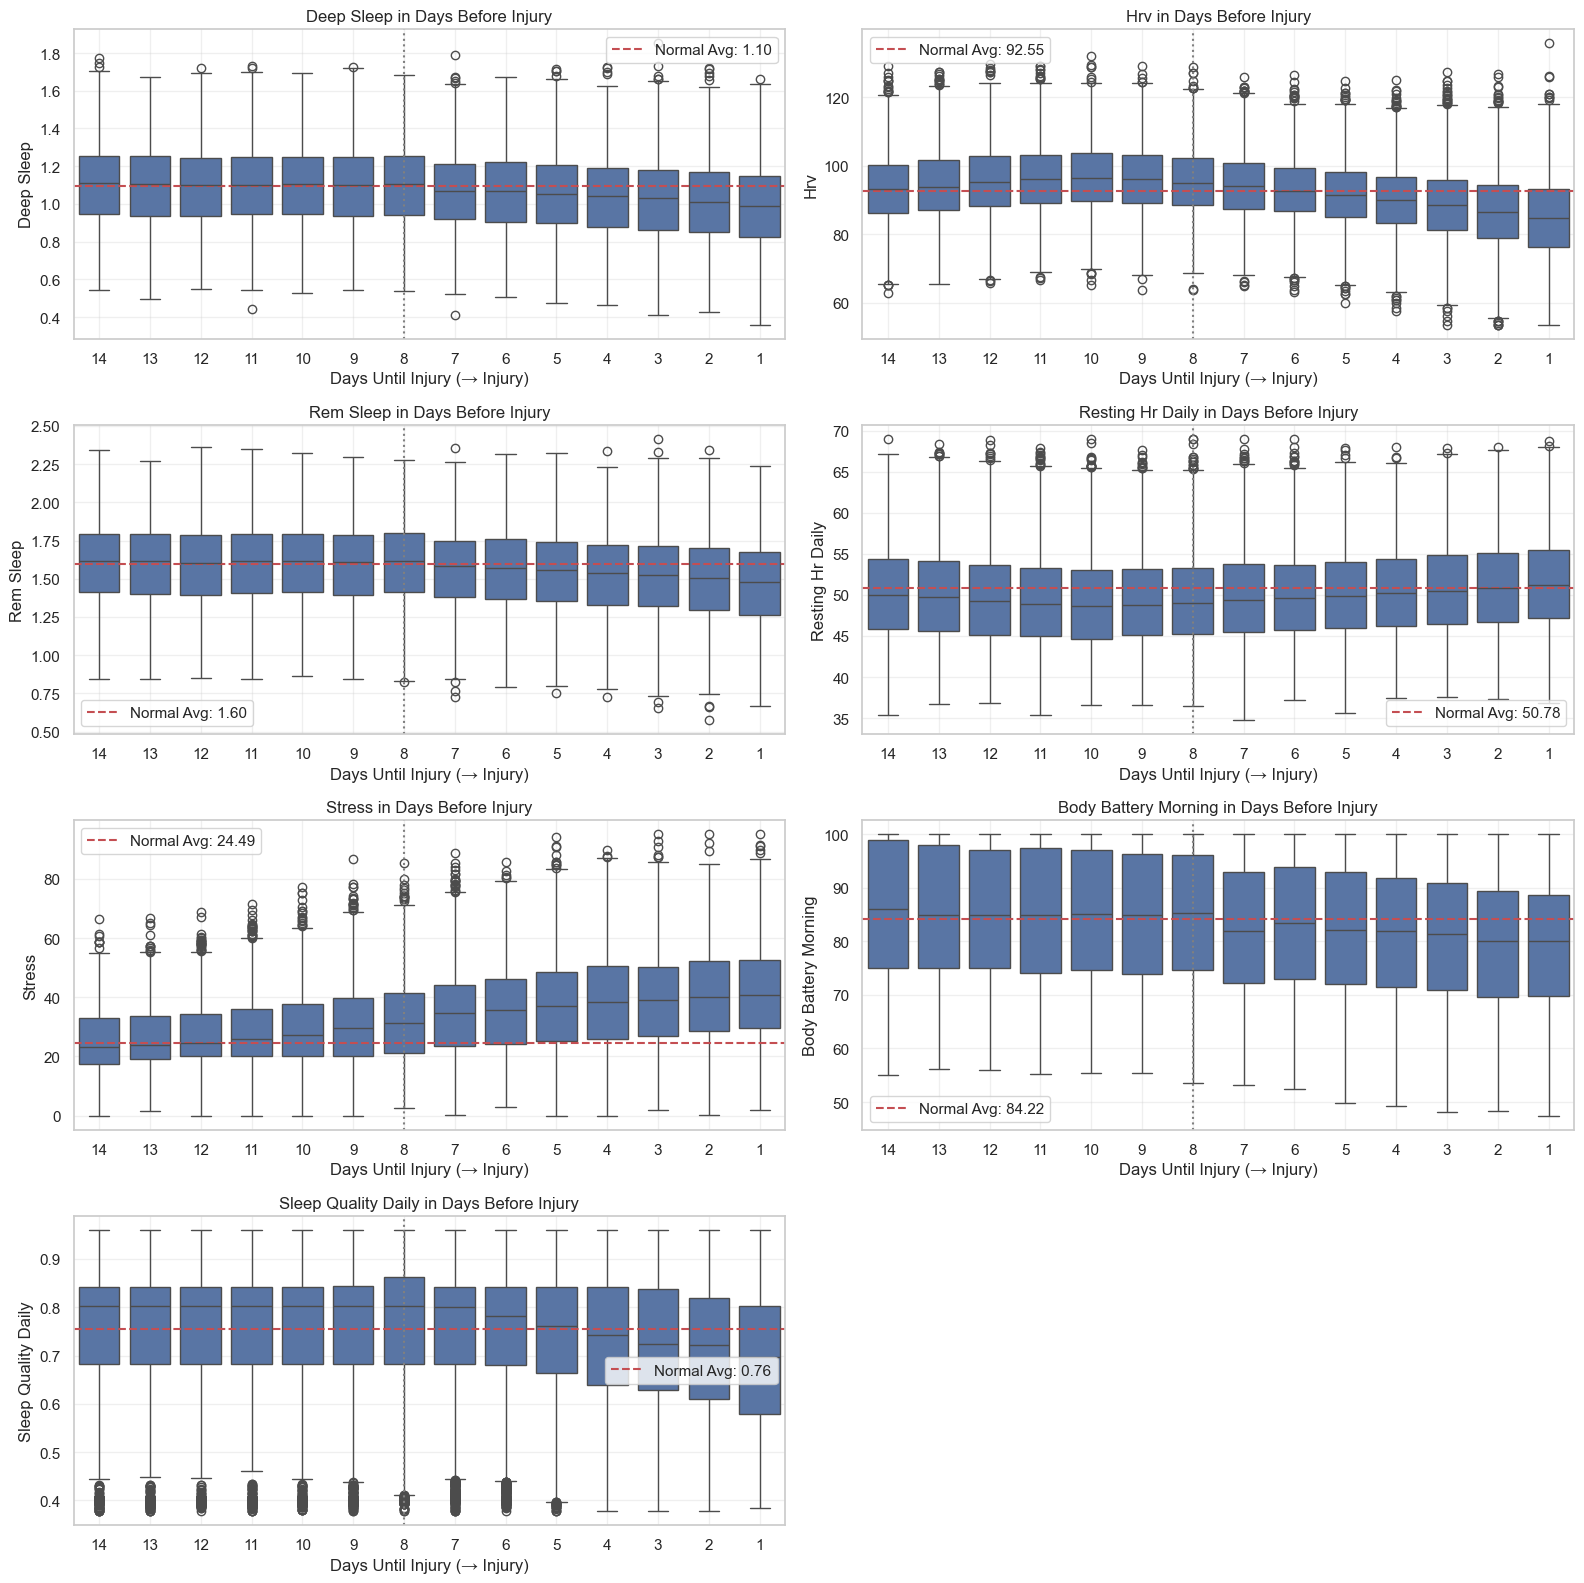

In [218]:
# Define all recovery metrics to include
recovery_metrics = [
    'deep_sleep',
    'hrv',
    'rem_sleep',
    'resting_hr_daily',
    'stress',
    'body_battery_morning',
    'sleep_quality_daily'
]

# Filter for metrics that exist in the dataframe
available_metrics = [col for col in recovery_metrics if col in merged_with_timing.columns]

# Calculate number of rows and columns for subplots
n_metrics = len(available_metrics)
n_rows = (n_metrics + 1) // 2  # 2 columns

# Create figure
fig, axs = plt.subplots(n_rows, 2, figsize=(16, 4 * n_rows))
axs = axs.flatten()  # Flatten for easier indexing

# Plot each metric
for i, metric in enumerate(available_metrics):
    # Filter data for pre-injury periods (14 days before injury)
    metric_data = pre_injury[pre_injury['days_until_injury'] <= 14].copy()
    
    # Create boxplot
    sns.boxplot(
        ax=axs[i],
        x='days_until_injury',
        y=metric,
        data=metric_data
    )
    
    # Reverse x-axis to show progression towards injury from left to right
    axs[i].invert_xaxis()
    
    # Add normal average line
    normal_avg = normal_training[metric].mean()
    axs[i].axhline(
        y=normal_avg,
        color='r',
        linestyle='--',
        label=f'Normal Avg: {normal_avg:.2f}'
    )
    
    # Formatting
    axs[i].set_title(f'{metric.replace("_", " ").title()} in Days Before Injury')
    axs[i].set_xlabel('Days Until Injury (→ Injury)')
    axs[i].set_ylabel(metric.replace('_', ' ').title())
    axs[i].legend()
    axs[i].grid(True, alpha=0.3)
    
    # Add a vertical line at day 7 to highlight the final week
    axs[i].axvline(x=7, color='gray', linestyle=':')

# Hide any unused subplots
for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()



The box blots visualize the seven key recovery metrics, that we also looked at above, during the 14 days preceding an injury event.

#### Sleep Metrics
- **Deep Sleep:** Stays relatively consistent around the normal average until day 8 before injury, then drops
- **REM Sleep:** similar behavior as deep sleep
- **Sleep Quality:** is stable until day seven before injury then drops significantely

#### Cardiovascualr Metrics
- **HRV:** downward trend starting approximately 7 days before injury, with values falling notably below the normal average of 92.55 in the final 5 days.
- **Resting Heart Rate:** increases slightly starting from day 5 pre-injury

#### Stress and Body Battery
- **Stress:** shows a clear upward trajectory across all 14 days, stress could be the earliest indicator
- **Body Battery:** Releatively stable until day 8 pre-injury, then starts degrading gradually

/var/folders/lx/jx57qljj5n74_nkl5qm8bqcr0000gn/T/ipykernel_93062/3196379809.py:64: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


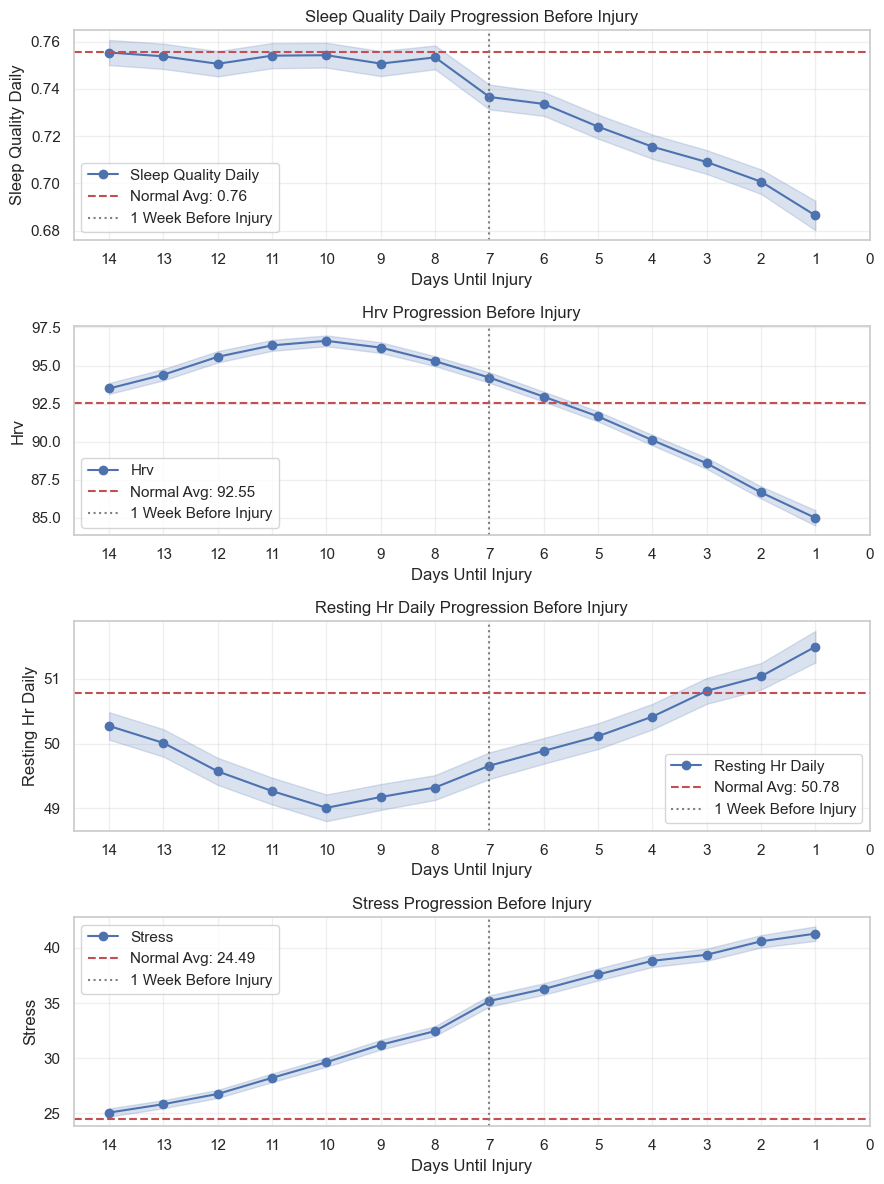

In [224]:
# Define metrics to plot
metrics = ['sleep_quality_daily', 'hrv', 'resting_hr_daily', 
           'stress']

# Create figure with subplots
# One row per metric
fig, axs = plt.subplots(len(metrics), 1, figsize=(9, 3 * len(metrics)), constrained_layout=True)

axs = axs.flatten()

# For each metric, calculate the mean and 95% CI for each day before injury
for i, metric in enumerate(metrics):
    # Filter to pre-injury periods (14 days or less)
    pre_injury_data = merged_with_timing[
        (merged_with_timing['is_pre_injury'] == True) & 
        (merged_with_timing['days_until_injury'] <= 14)
    ]
    
    # Group by days until injury and calculate statistics
    stats = pre_injury_data.groupby('days_until_injury')[metric].agg(
        mean='mean',
        std='std',
        count='count'
    ).reset_index()
    
    # Calculate 95% confidence interval
    stats['ci'] = 1.96 * stats['std'] / np.sqrt(stats['count'])
    stats['lower'] = stats['mean'] - stats['ci']
    stats['upper'] = stats['mean'] + stats['ci']
    
    # Calculate the normal average (baseline)
    normal_avg = merged_with_timing[
        (merged_with_timing['is_pre_injury'] == False) & 
        (merged_with_timing['injury'] == 0) & 
        ((merged_with_timing['days_until_injury'] > 14) | 
         (merged_with_timing['days_until_injury'] == -1))
    ][metric].mean()
    
    # Plot the time series with confidence intervals
    axs[i].plot(stats['days_until_injury'], stats['mean'], 'b-', marker='o', label=f'{metric.replace("_", " ").title()}')
    axs[i].fill_between(stats['days_until_injury'], stats['lower'], stats['upper'], color='b', alpha=0.2)
    
    # Add horizontal line for normal average
    axs[i].axhline(y=normal_avg, color='r', linestyle='--', label=f'Normal Avg: {normal_avg:.2f}')
    
    # Add vertical line at day 7
    axs[i].axvline(x=7, color='gray', linestyle=':', label='1 Week Before Injury')
    
    # Formatting
    axs[i].set_title(f'{metric.replace("_", " ").title()} Progression Before Injury')
    axs[i].set_xlabel('Days Until Injury')
    axs[i].set_ylabel(metric.replace('_', ' ').title())
    axs[i].legend()
    axs[i].grid(True, alpha=0.3)
    axs[i].invert_xaxis()  # To show progression towards injury from left to right
    
    # Set the x-axis ticks
    axs[i].set_xticks(range(14, -1, -1))

# Hide unused subplot
if len(metrics) < len(axs):
    axs[-1].axis('off')

plt.tight_layout()
plt.show()

#### Sleep Metrics
##### Deep Sleep

- Pre-Week 2 (Days 14-8): Values remain stable around the normal baseline of 1.10 hours
- Critical Week (Days 7-1): Shows a consistent downward trajectory, dropping sharply below baseline
- Final Day Before Injury: Reaches approximately 0.96 hours (13% below baseline)

##### REM Sleep

- Pre-Week 2 (Days 14-8): Fluctuates slightly but maintains values near the normal baseline of 1.60 hours
- Critical Week (Days 7-1): Progressive decline, following a similar pattern to deep sleep
- Final Day Before Injury: Drops to approximately 1.42 hours (11% below baseline)

##### Sleep Quality

- Pre-Week 2 (Days 14-8): Minor fluctuations within normal range (around 0.76)
- Critical Week (Days 7-1): Steady decline beginning at Day 7
- Final Day Before Injury: Reaches approximately 0.66 (13% below baseline)

#### Cardiovascular Metrics
##### HRV (Heart Rate Variability)

- Pre-Week 2 (Days 14-8): Elevated above normal baseline (92.59), suggesting good recovery
- Critical Week (Days 7-1): Dramatic decline beginning at Day 7
- Final Day Before Injury: Drops to approximately 85.5 (8% below baseline)

##### Resting HR Daily

- Pre-Week 2 (Days 14-8): Slightly below normal baseline of 51.09 BPM
- Critical Week (Days 7-1): U-shaped pattern with initial recovery followed by increase
- Final Day Before Injury: Rises to approximately 52.5 BPM (3% above baseline)

#### Stress and Body Battery
##### Stress

- Pre-Week 2 (Days 14-8): Gradual, consistent increase from baseline of 24.15
- Critical Week (Days 7-1): Accelerated increase continuing through to injury
- Final Day Before Injury: Reaches approximately 42 (74% above baseline)

##### Body Battery Morning

- Pre-Week 2 (Days 14-8): Fluctuates above baseline of 84.05
- Critical Week (Days 7-1): Clear decline beginning at Day 7
- Final Day Before Injury: Drops to approximately 76.5 (9% below baseline)

#### Key Insights

- Critical 7-Day Window: Almost all metrics show a clear pattern shift precisely at the 7-day mark before injury (vertical dotted line), suggesting this is a key intervention timeframe

##### Strongest Warning Signals:

- **Stress** (largest magnitude of change, increasing 74%)
- **Deep Sleep, REM Sleep, and Sleep Quality** (all declining 11-13%)
- **HRV** (significant drop beginning at Day 7)

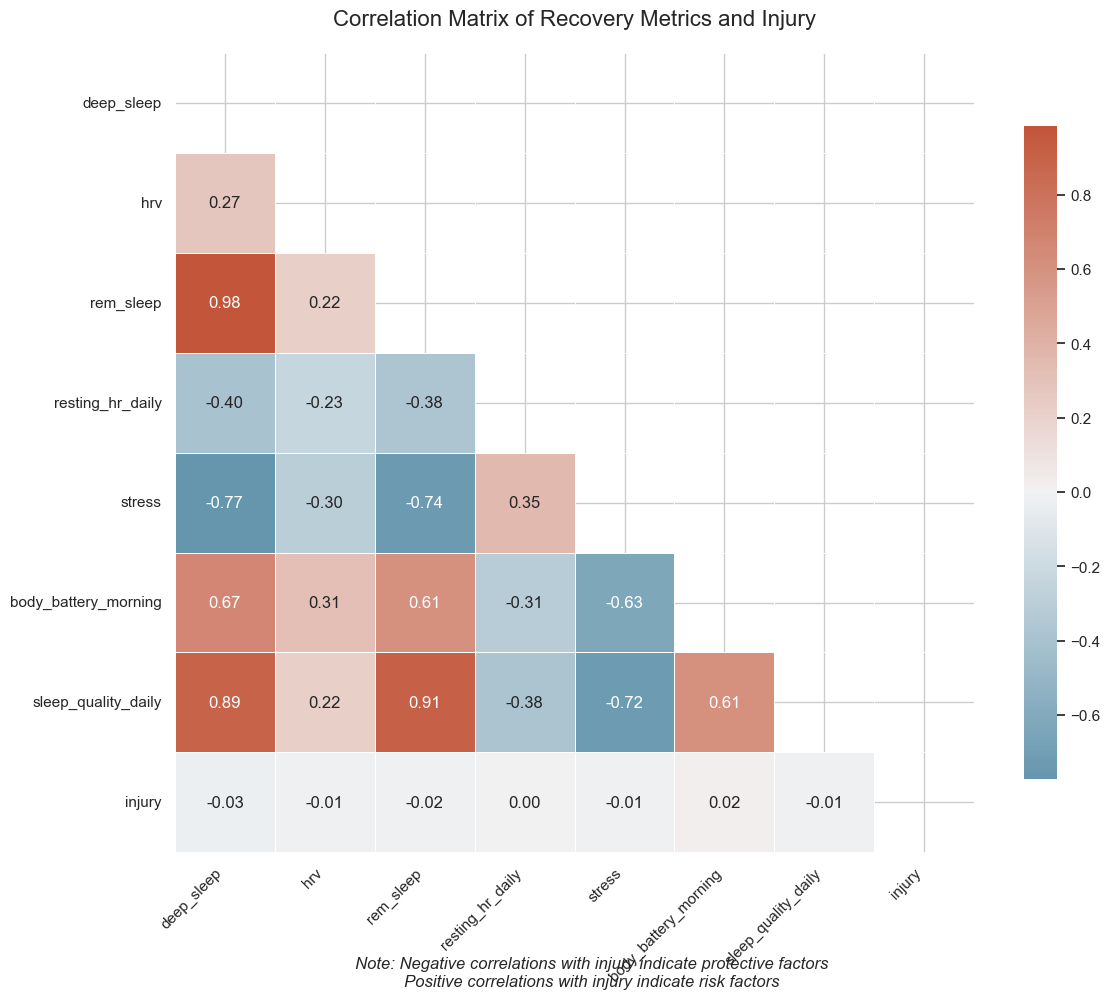

In [162]:
# Create correlation heatmap of metrics plus injury
# Filter for only the columns we need
metrics = ['deep_sleep', 'hrv', 'rem_sleep', 'resting_hr_daily', 
           'stress', 'body_battery_morning', 'sleep_quality_daily']

# Add injury column to analysis
columns_to_analyze = metrics + ['injury']

# Create correlation matrix
# We'll use the entire dataset, not just pre-injury periods
corr_matrix = merged_with_timing[columns_to_analyze].corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Create mask for upper triangle

# Custom diverging colormap with white at 0
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Create heatmap with annotations
heatmap = sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0,
                      annot=True, fmt=".2f", square=True, linewidths=.5,
                      cbar_kws={"shrink": .8})

# Formatting
plt.title('Correlation Matrix of Recovery Metrics and Injury', fontsize=16, pad=20)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')

# Add text annotations highlighting key relationships
plt.figtext(0.5, 0.01, 
            "Note: Negative correlations with injury indicate protective factors\n"
            "Positive correlations with injury indicate risk factors",
            horizontalalignment='center', fontsize=12, style='italic')

plt.tight_layout()
plt.show()

### Recovery Metric Interrelationships

#### Sleep Metrics Cluster

- **Deep Sleep and REM Sleep**: Exceptionally strong correlation (**0.98**), indicating these metrics capture nearly identical physiological processes
- **Sleep Quality**: Strongly correlated with both Deep Sleep (**0.89**) and REM Sleep (**0.91**), confirming the interdependence of sleep quality measures

#### Stress Relationships

- **Stress and Sleep**: Strong negative correlations with Deep Sleep (**-0.77**), REM Sleep (**-0.74**), and Sleep Quality (**-0.72**)
- **Stress and Body Battery**: Substantial negative correlation (**-0.63**), confirming stress depletes recovery resources

### Cardiovascular Metrics

- **HRV**: Moderately correlated with other recovery metrics (**0.22–0.31**), suggesting it captures partially independent information
- **Resting HR**: Negatively correlated with positive recovery metrics, particularly Deep Sleep (**-0.40**) and REM Sleep (**-0.38**)


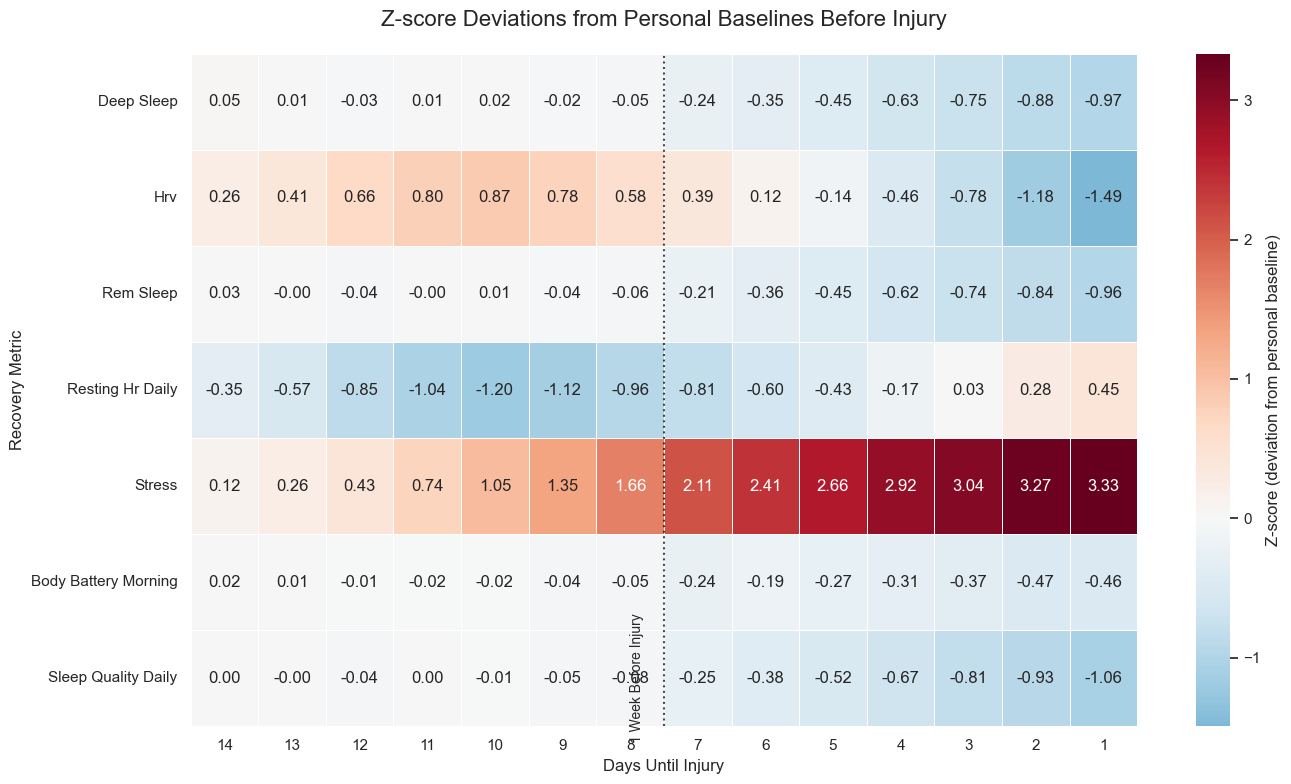

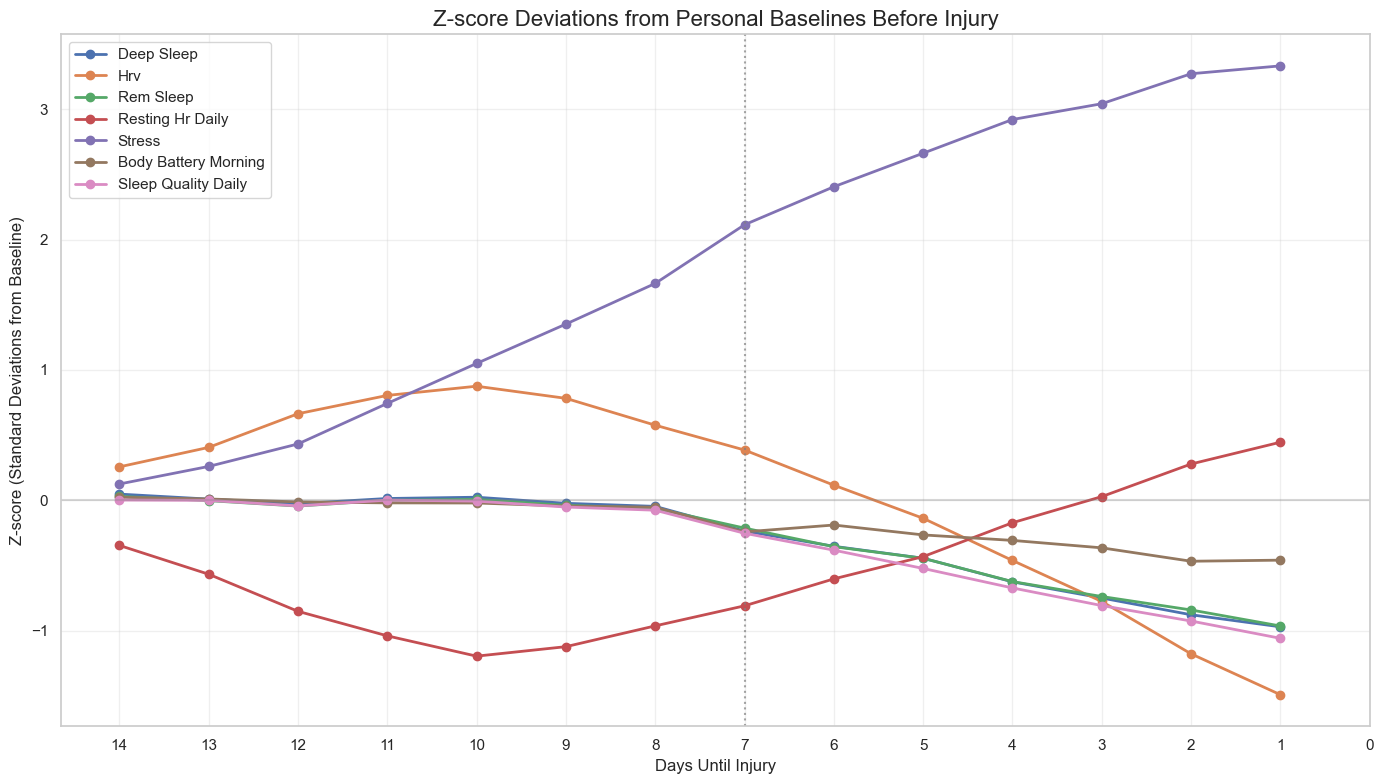

In [163]:
# Create Z-score deviation chart
# This shows how many standard deviations each metric deviates from 
# an athlete's personal baseline in the days before injury

# Define metrics
metrics = ['deep_sleep', 'hrv', 'rem_sleep', 'resting_hr_daily', 
           'stress', 'body_battery_morning', 'sleep_quality_daily']

# Create a new dataframe to store z-scores
z_scores = pd.DataFrame()

# Group by athlete to calculate personal baselines
athlete_ids = merged_with_timing['athlete_id'].unique()

for athlete_id in athlete_ids:
    athlete_data = merged_with_timing[merged_with_timing['athlete_id'] == athlete_id].copy()
    
    # Calculate baseline statistics from non-injury periods (more than 14 days before injury)
    baseline_data = athlete_data[
        (athlete_data['is_pre_injury'] == False) & 
        (athlete_data['injury'] == 0) & 
        ((athlete_data['days_until_injury'] > 14) | 
         (athlete_data['days_until_injury'] == -1))
    ]
    
    # Only proceed if we have sufficient baseline data
    if len(baseline_data) >= 10:  # Requiring at least 10 days of baseline data
        # Calculate mean and std for each metric for this athlete
        baseline_stats = {}
        for metric in metrics:
            baseline_stats[f"{metric}_mean"] = baseline_data[metric].mean()
            baseline_stats[f"{metric}_std"] = baseline_data[metric].std()
        
        # Calculate z-scores for pre-injury periods
        pre_injury_data = athlete_data[
            (athlete_data['is_pre_injury'] == True) & 
            (athlete_data['days_until_injury'] <= 14)
        ].copy()
        
        if len(pre_injury_data) > 0:
            for metric in metrics:
                # Avoid division by zero
                std_val = baseline_stats[f"{metric}_std"]
                if std_val == 0:
                    std_val = 1e-6
                
                # Calculate z-score
                pre_injury_data[f"{metric}_zscore"] = (
                    pre_injury_data[metric] - baseline_stats[f"{metric}_mean"]
                ) / std_val
            
            # Add to the z-scores dataframe
            z_scores = pd.concat([z_scores, pre_injury_data[['athlete_id', 'days_until_injury'] + 
                                                           [f"{m}_zscore" for m in metrics]]])

# Now create the visualization
# Group by days until injury and calculate average z-scores
z_agg = z_scores.groupby('days_until_injury')[[f"{m}_zscore" for m in metrics]].mean().reset_index()

# Create the heatmap data
heatmap_data = z_agg.set_index('days_until_injury')
heatmap_data.columns = [col.replace('_zscore', '') for col in heatmap_data.columns]
heatmap_data = heatmap_data.rename(columns={
    m: m.replace('_', ' ').title() for m in metrics
})

# Create the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data.T, cmap="RdBu_r", center=0, annot=True, fmt=".2f",
            linewidths=.5, cbar_kws={"label": "Z-score (deviation from personal baseline)"})

# Formatting
plt.title('Z-score Deviations from Personal Baselines Before Injury', fontsize=16, pad=20)
plt.xlabel('Days Until Injury')
plt.ylabel('Recovery Metric')
plt.gca().invert_xaxis()  # Show progression towards injury from left to right

# Add vertical line at day 7
plt.axvline(x=7, color='black', linestyle=':', alpha=0.7)
plt.text(7.5, len(metrics)-0.5, '1 Week Before Injury', 
         rotation=90, verticalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()

# Also create a line plot version
plt.figure(figsize=(14, 8))

# For each metric, create a line
for metric in metrics:
    zscore_col = f"{metric}_zscore"
    plt.plot(z_agg['days_until_injury'], z_agg[zscore_col], 
             marker='o', linewidth=2, label=metric.replace('_', ' ').title())

# Add zero line
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

# Add vertical line at day 7
plt.axvline(x=7, color='gray', linestyle=':', alpha=0.7)

# Formatting
plt.title('Z-score Deviations from Personal Baselines Before Injury', fontsize=16)
plt.xlabel('Days Until Injury')
plt.ylabel('Z-score (Standard Deviations from Baseline)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()  # Show progression towards injury from left to right

# Set x-ticks
plt.xticks(range(14, -1, -1))

plt.tight_layout()
plt.show()

### Stress

- **Most Dramatic Change**: Exhibits the largest deviation of any metric, reaching **+3.21 standard deviations** above baseline on the day before injury
- **Early Warning Signal**: Begins meaningful deviation (**+0.55σ**) as early as **12 days before injury**
- **Critical Acceleration**: Shows a step-change increase at the **7-day mark** (from **+1.44σ** to **+1.94σ**)
- **Extreme Deviation**: Crosses the **+2σ threshold** at **day 6**, indicating highly abnormal stress levels throughout the final week

### Sleep Metrics

- **Deep Sleep**: Progressive decline beginning at **day 7** (**-0.24σ**), reaching nearly **-1σ** by injury day
- **REM Sleep**: Follows similar pattern to deep sleep, with significant decline beginning at **day 7** (**-0.24σ**)
- **Sleep Quality**: Shows the **third-largest deviation** by **day 1** (**-1.12σ**), with decline accelerating after **day 7**
- **Consistency**: All three sleep metrics show minimal deviation in **days 14–8**, then uniform decline pattern

### HRV (Heart Rate Variability)

- **Unique Biphasic Pattern**: Initially elevated (**+0.25σ to +0.79σ**) during **days 14–8**, suggesting compensatory adaptation
- **Dramatic Reversal**: Begins declining after **day 8**, falling below baseline after **day 5**
- **Largest Range**: Shows the widest swing from **+0.79σ to -1.35σ** (**2.14σ total change**)
- **Severe Terminal Decline**: Second-largest negative deviation (**-1.35σ**) by injury day

### Resting HR

- **Unexpected Pattern**: Consistently below baseline in **days 14–8** (**-0.36σ to -1.03σ**)
- **Reversal Pattern**: Steadily returns toward and then above baseline in the final **3 days**
- **Small Terminal Deviation**: Reaches only **+0.11σ** by injury day, the smallest absolute deviation of any metric

### Body Battery Morning

- **Subtle Changes**: Shows the **smallest overall deviations** until the final days
- **Late Decline**: Only begins meaningful deviation after **day 3** (**-0.53σ by day 2**)
- **Moderate Impact**: Reaches **-0.50σ** by injury day, suggesting it's **less sensitive** than other metrics

## Conclusion: Recovery Metrics Predict Injury Despite Proper Training

Our analysis reveals that athletes sustained injuries despite following sound training plans, with recovery metrics showing significant warning signals while training variables remained appropriate. This confirms that monitoring recovery is essential even with well-structured training.

---

### Key Insights

#### Recovery Metrics Show Clear Patterns

- **Critical 7-day pre-injury window** identified across all metrics  
- **Stress** shows largest magnitude changes (up to **+3.21σ** from baseline)  
- **Sleep metrics and HRV** demonstrate consistent declines in the final week  
- **Personalized z-scores** provide stronger signals than absolute values  

#### Optimal Prediction Windows

- **7-day window** offers best balance of advance warning and accuracy  
- **14-day window** captures earliest deviations but includes more noise  
- **3–5 day window** shows strongest signals but offers limited intervention time  

#### Feature Engineering Opportunities

- **Rate of change metrics**: Calculate 3-day slopes for all recovery variables  
- **Composite scores**: Combine stress, sleep quality, and HRV into weighted risk scores  
- **Threshold violations**: Track consecutive days below personal baseline thresholds  
- **Reversal patterns**: Monitor HRV's biphasic pattern (elevation followed by decline)  
- **Stress-to-recovery ratios**: Develop stress and stress ratios  
- **Weekly pattern disruptions**: Compare individual's typical weekly patterns to current week  

---

### Practical Applications

These findings suggest implementing monitoring systems that track **personalized recovery deviations** with **7-day rolling windows**, with particular emphasis on:

- **Stress levels**  
- **Sleep quality metrics**  
- **HRV patterns**

Early intervention should be triggered when **multiple metrics** begin showing concerning trajectories, allowing for training modifications or recovery interventions **before injury occurs**.
